In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from pathlib import Path
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns
from scipy.stats import linregress

import sys
sys.path.append('..')
from src.postprocessing import MergerRates
from src.constants import COMPACT_OBJ_DIR_PATH, GALAXYGRID_DIR_PATH
from src.utils import ZOH_to_FeH

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [6]:
sample_path = Path(COMPACT_OBJ_DIR_PATH, '12x10_1222_co_sample')
zams_grid_path = Path(GALAXYGRID_DIR_PATH, 'sfrgrid_midmet_10z_plusbound_10met_final.pkl')
model_id = '1222'

# Sample loading and setup

In [7]:
sfrd_model = 'midmet'
invariant_imf = False

In [8]:
mergerrates = MergerRates(sample_path, zams_grid_path, sfrd_model, invariant_imf=invariant_imf, extended_load=True, load_bcos_only=True)

In [9]:
mergerrates.load_sample_to_memory(batches_n=12)

INFO MainProcess Search sample folder for valid files...
INFO MainProcess Found 0 valid files, loading to sample dataframe...
INFO MainProcess Added 0.00e+00 rows sub-sample dataframe to sample dataframe.
INFO MainProcess Done loading subsample to memory. Total memory usage from sample dataframe: 0.00 GB
INFO MainProcess Added 0.00e+00 rows sub-sample dataframe to sample dataframe.
INFO MainProcess Done loading subsample to memory. Total memory usage from sample dataframe: 0.00 GB


KeyboardInterrupt: 

In [9]:
import pickle as pkl
sample_starforming_mass_dict_path = Path('.', 'sample_1222_1e8_starforming_mass_dict.pkl')

In [10]:
with open(sample_starforming_mass_dict_path, 'rb') as f:
    sample_starforming_mass_dict = pkl.load(f)

# BHBH Mergers

## Full

In [359]:
from src.constants import Z_SUN, T04_MZR_params_list, M09_MZR_params_list, KK04_MZR_params_list, PP04_MZR_params_list, \
    C20_DIR_PATH, REDSHIFT_SFRD_DATA_PATH, LOWMET_SFRD_PATH, MIDMET_SFRD_DATA_PATH, HIGHMET_SFRD_DATA_PATH, \
    LOWMET_CANON_SFRD_PATH, MIDMET_CANON_SFRD_DATA_PATH, HIGHMET_CANON_SFRD_DATA_PATH
from src.utils import ZOH_to_FeH, FeH_to_Z, interpolate

In [394]:
class ChruslinskaSFRD:
    """Star formation rate density grid.

    Loads the precomputed star formation rate density (SFRD) grid over redshift (z) and metallicity (Z_OH) and finds the
    SFRD corresponding to the (z,Z) pair closest to the (z,Z) provided by the user. Allows for choosing between the
    extreme low- and high-metallicity models, or a moderate-metallicity model.

    Attributes
    ----------
    MODEL_PATH_DICT : dict
        Dictionary containing the paths to the precomputed SFRD grids.
    SFRD_ZOH_ARRAY : numpy array
        Array of Z_OH metallicity values making up one axis of the SFRD grids.
    SFRD_Z_ARRAY : numpy array
        Array of Z metallicity values making up one axis of the SFRD grid.
    model : str
        Choice of SFRD grid model.
    sfrd_redshift_array : numpy array
        Array of redshifts making up the other axis of the SFRD grid.
    sfrd_dtime_array : numpy array
        Array of time steps defining the SFRD grid redshifts.
    logsfrd_array : numpy array
        Log10(SFRD) array over the redshift-metallicity grid.

    Methods
    -------
    load_grid()
        Loads the SFRD grid from disk.
    get_logsfrd(feh, redshift)
        Returns the log10(SFRD) corresponding to the pair in the grid closest to the given (feh, redshift).

    Warns
    -----
    UserWarning
        If get_logsfrd(feh, redshift) is run before set_grid().

    Notes
    -----
    The precomputed SFRD grids are by Chruslinska et al. (2020) [1]_ and were calculated with the same GSMF, SFMR and
    MZR relations employed in this module. Different combinations of the different relation options lead to the three
    grid options, differentiated by the degree to which the SFR distribution is shifted towards higher or lower
    metallicities. These grids already take into account the corrections for environment-dependent IMF treated in the
    Corrections class.

    References
    ----------
    .. [1] Chruslinska, M., Jerabkova, T., Nelemans, G., Yan, Z. (2020). The effect of the environment-dependent IMF on
        the formation and metallicities of stars over cosmic history. A&A, 636, A10. doi:10.1051/0004-6361/202037688
    """

    MODEL_PATH_DICT = {'lowmet': LOWMET_SFRD_PATH,
                       'midmet': MIDMET_SFRD_DATA_PATH,
                       'highmet': HIGHMET_SFRD_DATA_PATH
                       }
    CANON_MODEL_PATH_DICT = {'lowmet': LOWMET_CANON_SFRD_PATH,
                             'midmet': MIDMET_CANON_SFRD_DATA_PATH,
                             'highmet': HIGHMET_CANON_SFRD_DATA_PATH
                            }
    SFRD_ZOH_ARRAY = np.linspace(5.3, 9.7, 201)
    SFRD_ZOH_CENTERS_ARRAY = np.linspace(5.3, 9.7, 200)
    SFRD_FEH_ARRAY = np.array([ZOH_to_FeH(zoh) for zoh in SFRD_ZOH_ARRAY])
    SFRD_Z_ARRAY = np.array([FeH_to_Z(feh) for feh in SFRD_FEH_ARRAY])
    SFRD_Z_CENTERS_ARRAY = np.array([FeH_to_Z(ZOH_to_FeH(zoh)) for zoh in SFRD_ZOH_CENTERS_ARRAY])

    def __init__(self, model='midmet', canon=False, per_redshift_met_bin=False):
        """
        Parameters
        ----------
        model : {'midmet', 'lowmet', 'highmet'}, default: 'midmet'
            Option of SFRD grid model.
        """

        self.model = model
        self.canon = canon
        self.sfrd_redshift_array = None
        self.sfrd_dtime_array = None
        self.per_redshift_met_bin = per_redshift_met_bin
        self.logsfrd_array = np.empty((2, 0))

    def _set_sfrd_redshift_array(self):
        """Set redshift and timestep arrays corresponding to the SFRD grids from the redshift/time data file."""
        redshift_time_data = np.genfromtxt(REDSHIFT_SFRD_DATA_PATH)
        self.sfrd_redshift_array = np.concatenate((redshift_time_data[:, 1], [0.0]))
        self.sfrd_dtime_array = redshift_time_data[:, 2]

    def _set_sfrd_array(self):
        """Set grid SFRD values."""
        if self.canon:
            sfrd_data_path = self.CANON_MODEL_PATH_DICT[self.model]
        else:
            sfrd_data_path = self.MODEL_PATH_DICT[self.model]
        self.logsfrd_array = np.genfromtxt(sfrd_data_path)
        for i, row in enumerate(self.logsfrd_array):
            for j, col in enumerate(row):
                dt = self.sfrd_dtime_array[i]
                #self.logsfrd_array[i, j] /= dt
                if self.per_redshift_met_bin:
                    dz = self.sfrd_redshift_array[i] - self.sfrd_redshift_array[i+1]
                    dfeh = self.SFRD_FEH_ARRAY[j+1] - self.SFRD_FEH_ARRAY[j]
                    self.logsfrd_array[i, j] /= dz*dfeh
                if self.logsfrd_array[i, j] == 0.0:
                    self.logsfrd_array[i, j] = np.nan
                else:
                    self.logsfrd_array[i, j] = np.log10(self.logsfrd_array[i, j])

    def set_grid(self):
        """Build redshift and SFRD arrays corresponding to the grid from the data files."""
        self._set_sfrd_redshift_array()
        self._set_sfrd_array()

    def get_logsfrd(self, feh, redshift):
        """For a given [Fe/H],redshift pair, find the log10(SFRD) corresponding to the closest pair in the grid.

        Parameters
        ----------
        feh : float
            The desired [Fe/H].
        redshift : float
            The desired redshift.

        Returns
        -------
        logsfrd : float
            Log10(SFRD) corresponding to the pair in the grid closest to the given feh,redshift.

        Warns
        -----
        UserWarning
            If the SFRD grid has not been loaded yet (load_grid() not run).

        Warnings
        --------
        The user should bear in mind the grids range from -4 to 1.7 in metallicity and 0 to 10 in redshift. Passing
        values outside these ranges will always return the edges of the grid.
        """

        if self.sfrd_redshift_array is None:
            warnings.warn('SFRD grid not loaded. Please run load_grid() first.')
            return
        z = Z_SUN * 10 ** feh
        redshift_i = np.argmin(np.abs(self.sfrd_redshift_array[:-1] - redshift))
        z_i = np.argmin(np.abs(self.SFRD_Z_CENTERS_ARRAY - z))
        logsfrd = self.logsfrd_array[redshift_i,z_i]
        return logsfrd

In [395]:
mergerrates._new_method = True
mergerrates._convert_time = False

In [396]:
def _get_sfrd(self):
    sfrd = ChruslinskaSFRD(self.sfrd_model, self.canon_sfrd, per_redshift_met_bin=self._new_method)
    sfrd.set_grid()
    return sfrd

In [397]:
mergerrates.sfrd = mergerrates._get_sfrd()

In [398]:
mergerrates.sfrd = _get_sfrd(mergerrates)

In [399]:
mergerrates.canon_sfrd

False

In [400]:
mergerrates._new_method

True

In [401]:
mergerrates.sfrd.per_redshift_met_bin

True

In [402]:
mergerrates._convert_time

False

In [14]:
merger_class = 'BHBH'
time_resolution = 0.1
mergerrates.set_merger_df(merger_class)

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df.Coalescence_Time = self.merger_df.Coalescence_Time / 1e9  # yr -> Gyr
/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df['Age_Merger'] = self._get_merger_age(self.merger_df)
/home/lucasmdesa/Documents/Compact Merger Popul

In [548]:
mergerrates._set_bins(time_resolution)
#mergerrates._set_bins(1)

In [821]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    print(mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'])
    print((mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'][1]+mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'][0])/2)

(0.0, 0.0208467836907175)
0.01042339184535875
(0.3939733380094157, 0.5248447833014318)
0.45940906065542375
(0.6809432269870406, 0.8723444133180098)
0.7766438201525252
(0.8723444133180098, 1.115747164985906)
0.994045789151958
(1.115747164985906, 1.4411682395825471)
1.2784577022842267
(1.4411682395825471, 1.9091293557323952)
1.6751487976574713
(1.4411682395825471, 1.9091293557323952)
1.6751487976574713
(1.9091293557323952, 2.665170150030571)
2.287149752881483
(1.9091293557323952, 2.665170150030571)
2.287149752881483
(2.665170150030571, 4.187681942408791)
3.426426046219681
(4.187681942408791, 9.999999999999995)
7.0938409712043935
(4.187681942408791, 10)
7.093840971204395


In [822]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    lowedge_i = next((i for i, x in enumerate(mergerrates._physical_redshift_bin_edges) if x <= redshift), None)
    if lowedge_i is None:
        lowedge = 0.0
        upedge = mergerrates._physical_redshift_bin_edges[-1]
    elif lowedge_i == 0:
        lowedge = mergerrates._physical_redshift_bin_edges[1]
        upedge = 10
    else:
        lowedge = mergerrates._physical_redshift_bin_edges[lowedge_i]
        upedge = mergerrates._physical_redshift_bin_edges[lowedge_i-1]        
    mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'] = (lowedge, upedge)
    #dz_zams = upedge - lowedge
    #print(redshift, lowedge, upedge, dz_zams, 
#          mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges']
#         )

In [823]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    print(mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'])
    print((mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'][1]+mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'][0])/2)

(0.0, 0.0208467836907175)
0.01042339184535875
(0.3939733380094157, 0.5248447833014318)
0.45940906065542375
(0.6809432269870406, 0.8723444133180098)
0.7766438201525252
(0.8723444133180098, 1.115747164985906)
0.994045789151958
(1.115747164985906, 1.4411682395825471)
1.2784577022842267
(1.4411682395825471, 1.9091293557323952)
1.6751487976574713
(1.4411682395825471, 1.9091293557323952)
1.6751487976574713
(1.9091293557323952, 2.665170150030571)
2.287149752881483
(1.9091293557323952, 2.665170150030571)
2.287149752881483
(2.665170150030571, 4.187681942408791)
3.426426046219681
(4.187681942408791, 9.999999999999995)
7.0938409712043935
(4.187681942408791, 10)
7.093840971204395


In [549]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [550]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [551]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

Text(0.5, 0, '$z_\\mathrm{merger}$')

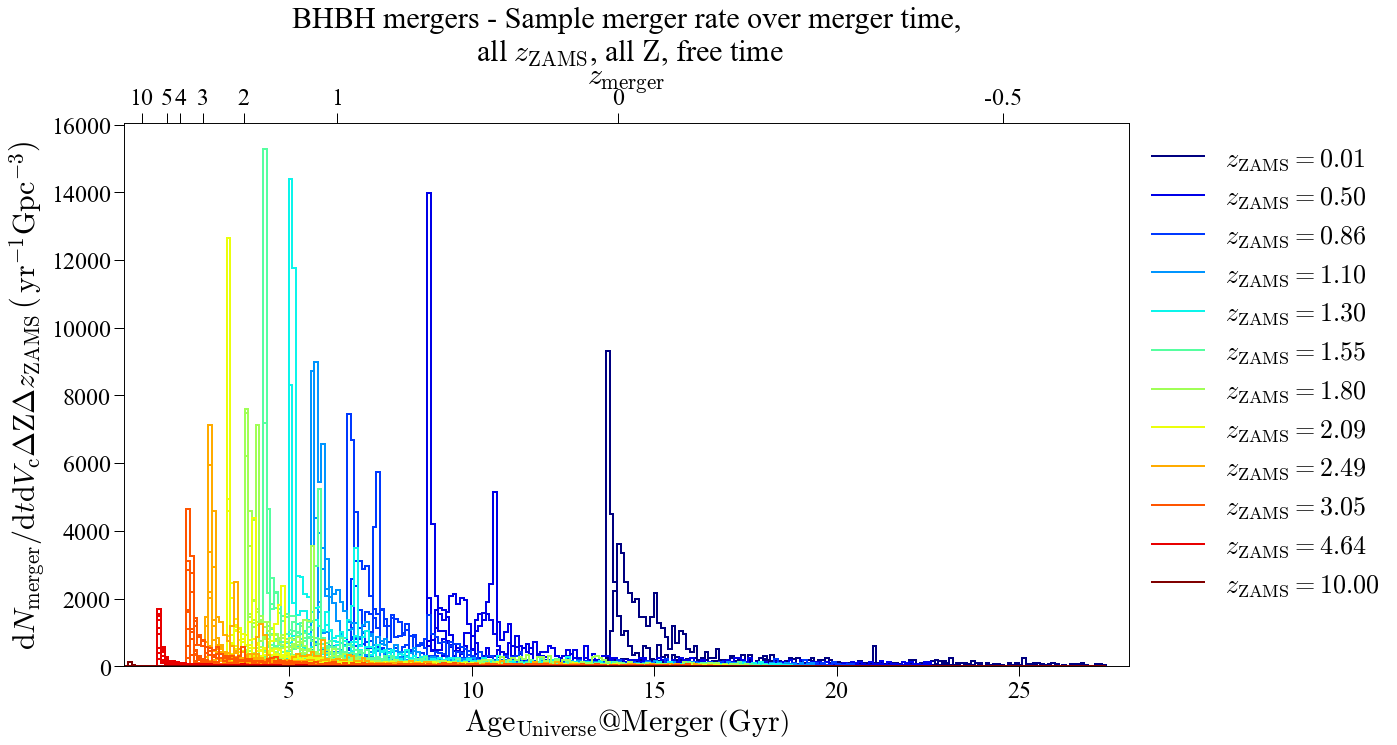

In [552]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':', '.-']*3
plot_alphas = np.linspace(0.2, 1, 10)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i_redshift, (redshift, color) in enumerate(zip(plot_redshifts, plot_colors)):
    for i_feh, feh in enumerate(mergerrates.sample_feh_arr[i_redshift]):
        age_bin_heights = mergerrates._dz_dfeh_dage_mrates_arr[i_redshift, i_feh]
        if i_feh == 0:
            label = f'$z_\mathrm{{ZAMS}}={redshift:.2f}$'
        else:
            label = None
        ax.stairs(age_bin_heights/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=label, lw=2)    
        #ax.plot(age_bin_centers, age_bin_heights/y_norm, color=color, alpha=1, ls='-', label=label, lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#ax.set_yscale('log')
ax.set_xlim(0, 28)
ax.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
axx2 = ax.twiny()
axx2.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
zs = [-0.5, 0, 1, 2, 3, 4, 5, 10]
ts = [cosmo.lookback_time(np.inf).value-cosmo.lookback_time(z).value for z in zs]
axx2.set_xlim(0, 28)
axx2.set_xticks(ts)
axx2.set_xticklabels(zs)
axx2.set_xlabel(r'$z_\mathrm{merger}$')

In [553]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


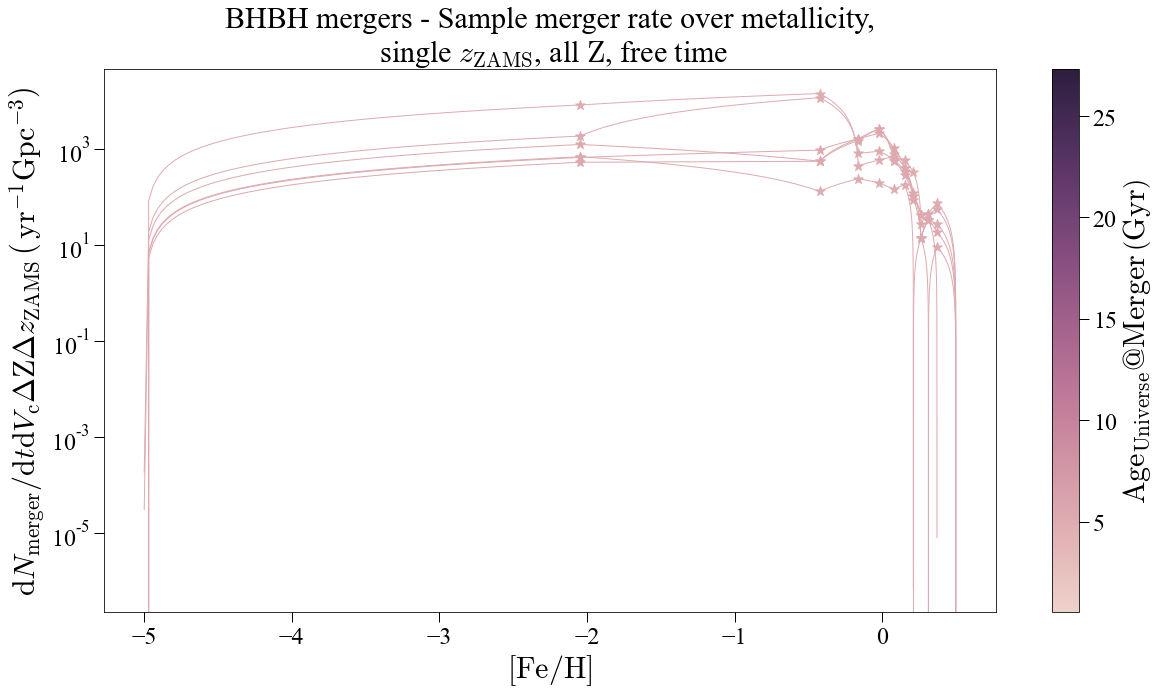

In [554]:
fig, ax = plt.subplots(figsize=(20,10))
plot_linestyles = ['-', '--', ':']
plot_linewidhts = [3, 2, 1]
plot_markerstyles = ['o', 's', '^', '*', '+', 'x', 'o', 's', '^', '*']*2
plot_linestyles = ['-', '--', ':']*4
plot_markersizes = [35, 30, 20, 10, 5]*2

age_bin_centers = mergerrates._full_age_bin_centers

plot_colors = [(age-min(age_bin_centers))/(max(age_bin_centers)-min(age_bin_centers)) for age in age_bin_centers]
plot_colors = [cm_cubehelix(c) for c in plot_colors]

age_fits = mergerrates._per_age_redshift_feh_fits
feh_redshift_age_array = mergerrates._dz_dfeh_dage_mrates_arr

y_norm = 1e0
for i_age, (age, c) in enumerate(zip(age_bin_centers, plot_colors[:50])):
    for i_redshift, redshift in enumerate(mergerrates.sample_redshift_arr[:5]):
        for i_feh, feh in enumerate(np.concatenate(([mergerrates.min_feh],
                                                    mergerrates.sample_feh_arr[i_redshift],
                                                    [mergerrates.max_feh]))):
            if i_feh == 0 or i_feh == mergerrates.sample_feh_arr[i_redshift].shape[0]+1:
                mrate = 0
            else:
                mrate = feh_redshift_age_array[i_redshift, i_feh-1, i_age]
            ax.scatter(feh, mrate/y_norm, color=c, marker='*', s=100, alpha=1)
            try:
                feh0, feh1, slope, intercept = age_fits[i_age][i_redshift][i_feh]
                plot_fehs = np.linspace(feh0, feh1, 100)
                plot_rates = plot_fehs*slope + intercept
                ax.plot(plot_fehs, plot_rates/y_norm, c=c, lw=1, ls='-')
            except:
                pass
                

ax.set_yscale('log')
#ax.set_ylim(1e-5, 1e3)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel('$\mathrm{[Fe/H]}$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over metallicity,\n single $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#handles, labels = ax.get_legend_handles_labels()

#for redshift, mst in zip(mergerrates.sample_redshift_arr, plot_markerstyles):
#    point = Line2D([0], [0], label=f'$z={redshift:.2f}$', marker=mst, markersize=20, markeredgecolor='k',
#                  markerfacecolor='None', linestyle='')
#    handles.extend([point])

#ax.legend(handles=handles, frameon=False, ncol=2)

sm = cm.ScalarMappable(cmap=cm_cubehelix, norm=plt.Normalize(vmin=age_bin_centers.min(), vmax=age_bin_centers.max()))
cb = fig.colorbar(sm)
cb.set_label(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

Text(0.5, 0, '$z_\\mathrm{merger}$')

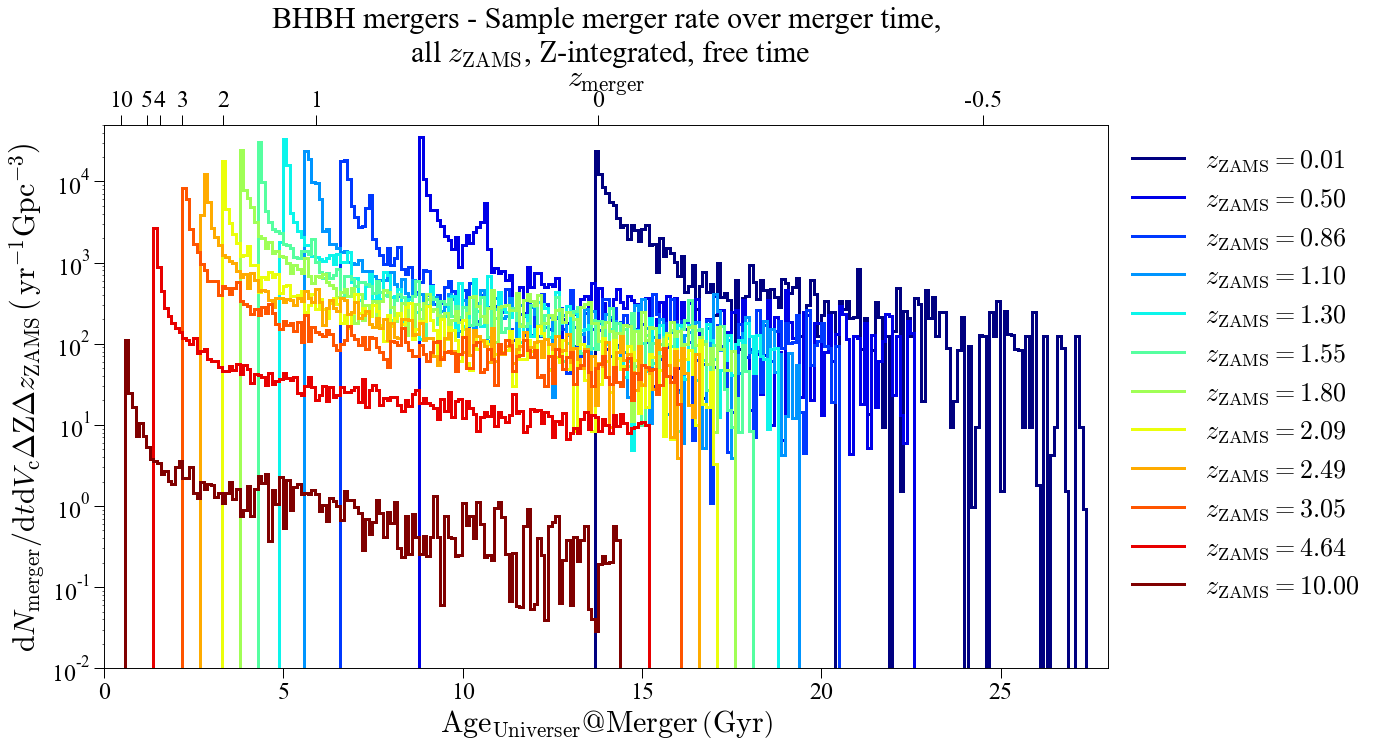

In [555]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=3)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universer}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 28)

ax.set_ylim(1e-2, 5e4)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 28)
zticks = [10, 5, 4, 3, 2, 1, 0, -0.5]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

In [556]:
mergerrates._set_dz_dpopage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$ if $z_\\mathrm{ZAMS}=10$')

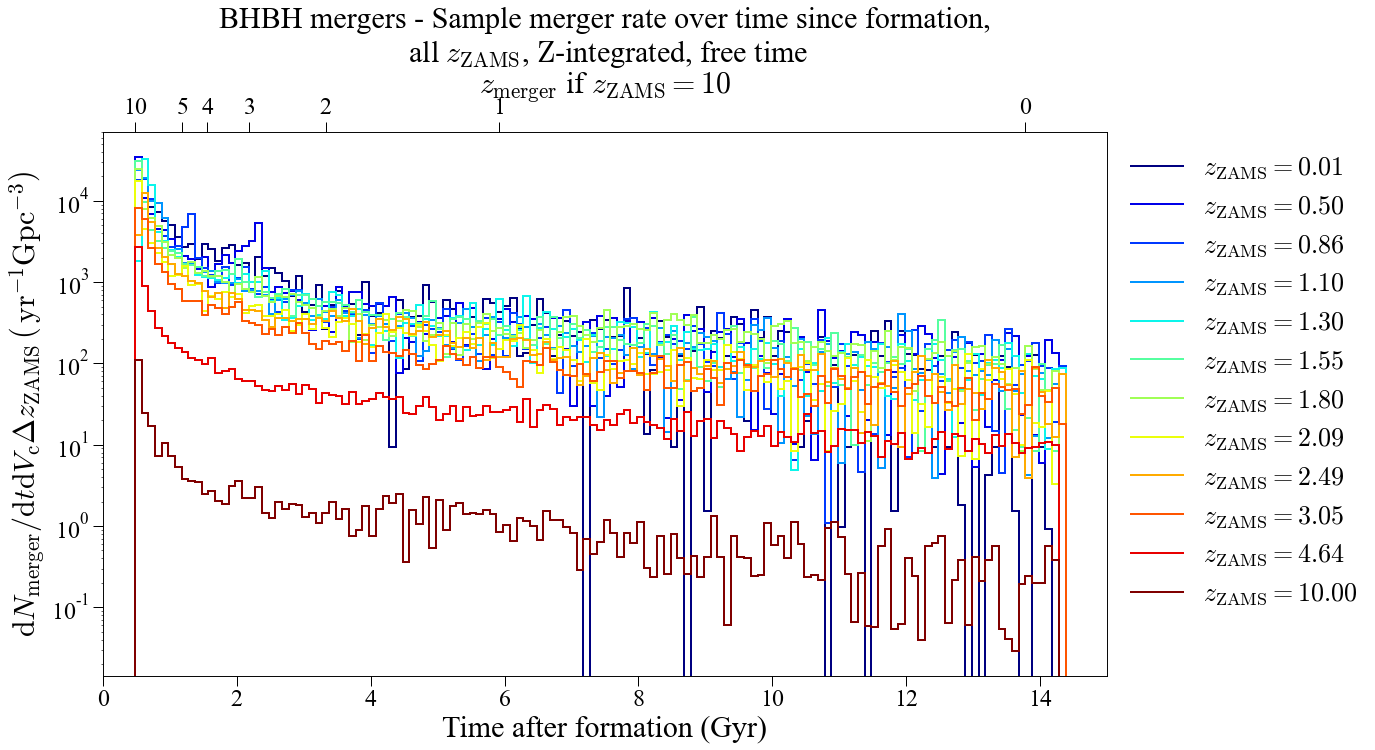

In [557]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

cmap = cm.jet
min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cmap(c) for c in plot_colors]
plot_colors = [cmap(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i, (redshift, redshift_mrate_array, color) in enumerate(zip(plot_redshifts, mergerrates._dz_dpopage_mrates_arr, plot_colors)):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel('Time after formation (Gyr)')
ax.set_title(f'{merger_class} mergers - Sample merger rate over time since formation,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
#ax.set_ylim(1e-3, 1e3)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

In [558]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [559]:
mergerrates._set_ip_dz_dage_mrates_arr()

[Text(13.768899116929322, 1, '0'),
 Text(5.922228427916887, 1, '1'),
 Text(3.3267847092936784, 1, '2'),
 Text(2.1782808536748703, 1, '3'),
 Text(1.5628233511789464, 1, '4'),
 Text(1.1900242903826443, 1, '5'),
 Text(0.479174188974518, 1, '10')]

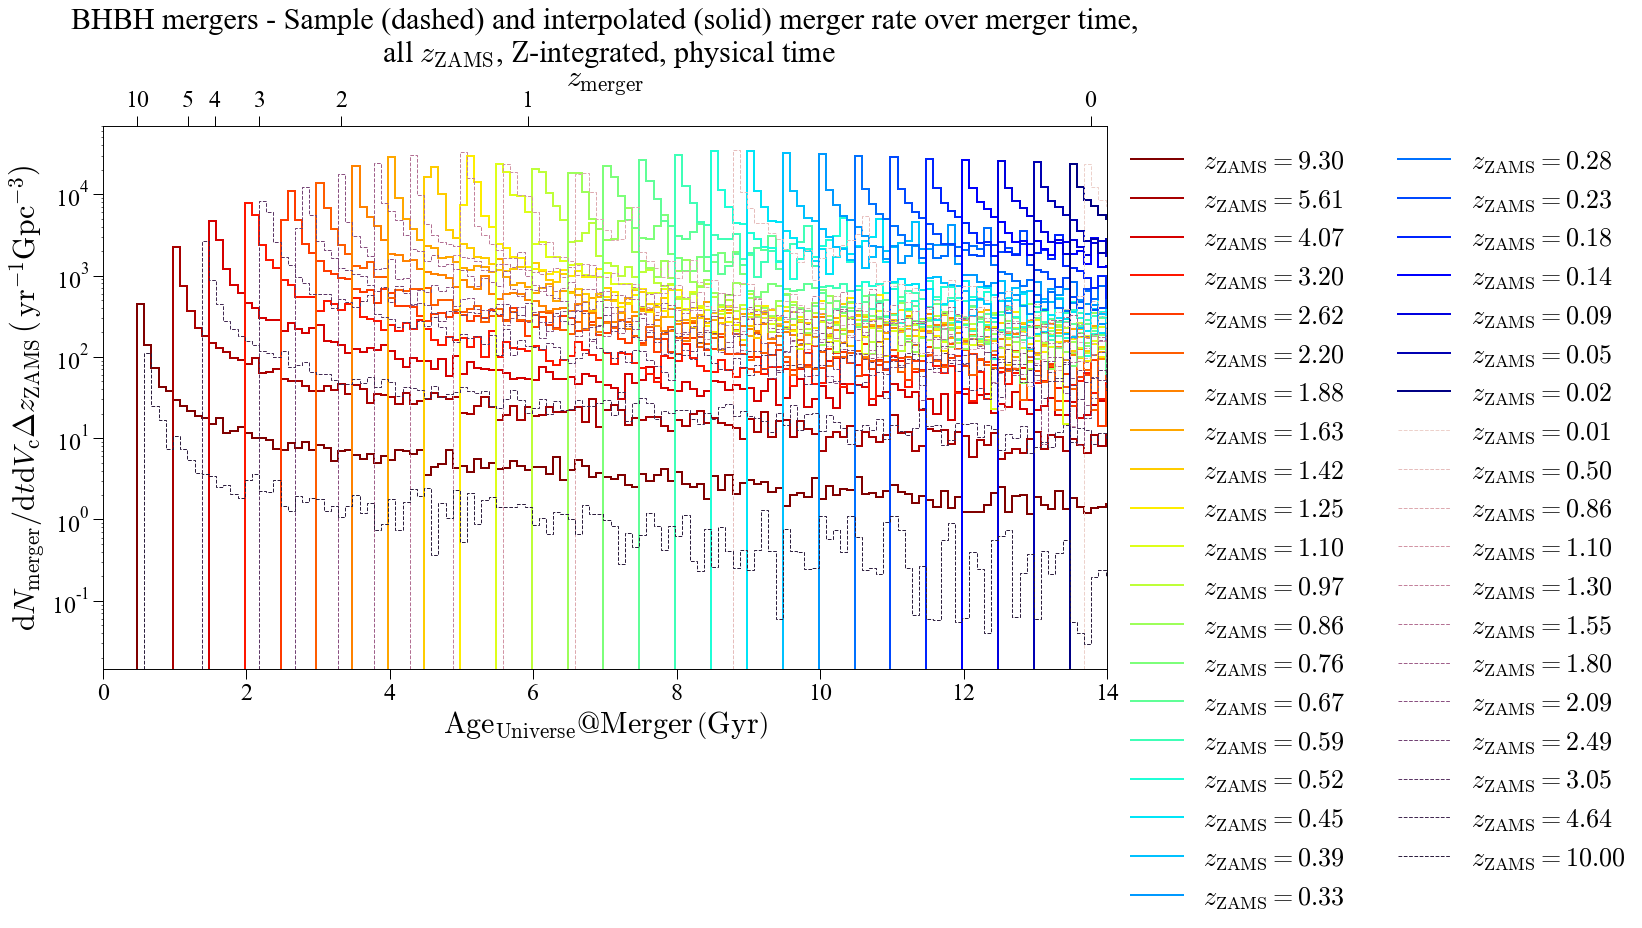

In [560]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr
ip_plot_redshifts = mergerrates.ip_redshift_arr

#min_color = 0
#plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in ip_plot_redshifts][::-1]
#plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
#plot_colors = [cm.jet(c) for c in plot_colors]
ip_plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(ip_plot_redshifts))[::-1]]
plot_colors = [cm_cubehelix(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(mergerrates.ip_redshift_arr[::5], mergerrates._ip_dz_dage_mrates_arr[::5], ip_plot_colors[::5]):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    

for redshift, redshift_mrate_array, color in zip(mergerrates.sample_redshift_arr, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='--', lw=1, label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$')    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=2)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample (dashed) and interpolated (solid) merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, physical time')
#ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_yscale('log')
#ax.set_ylim(1e-3, 1e3)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, 14)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

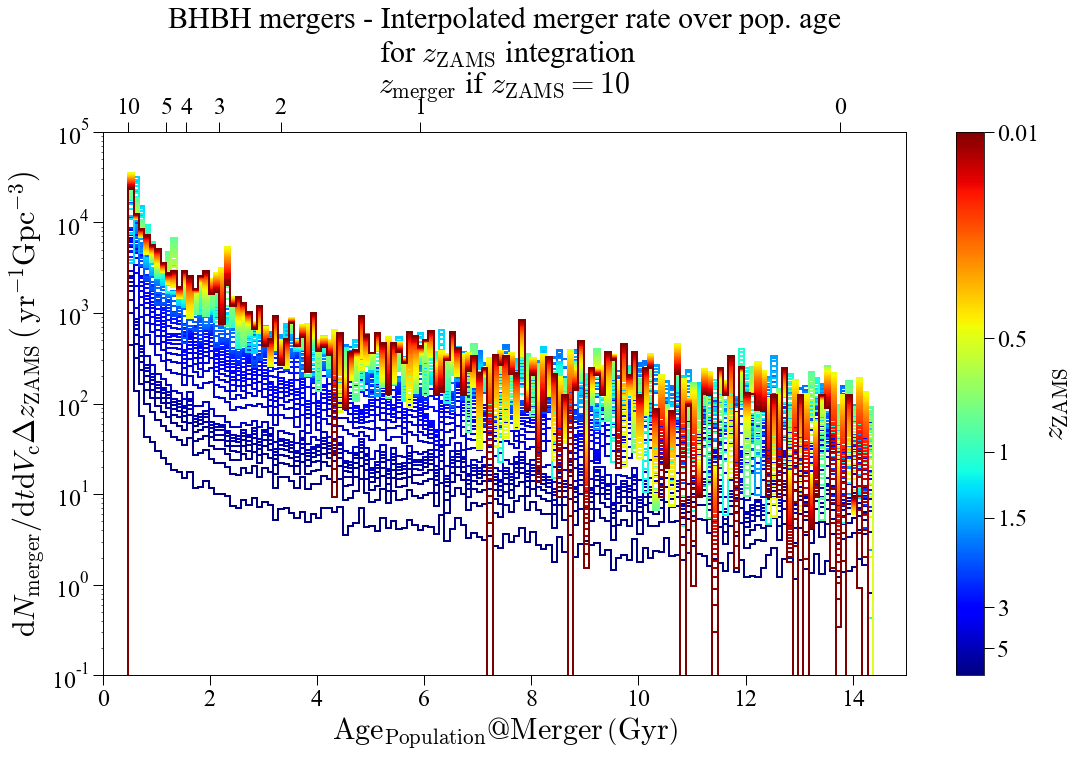

In [561]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.ip_redshift_arr
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._ip_dz_dpopage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Population}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over pop. age\n for $z_\mathrm{{ZAMS}}$ integration')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
ax.set_ylim(1e-1, 1e5)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

sm = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=plot_ages.min(), vmax=plot_ages.max()))
cb = fig.colorbar(sm)
redshift_ticks = [5, 3, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

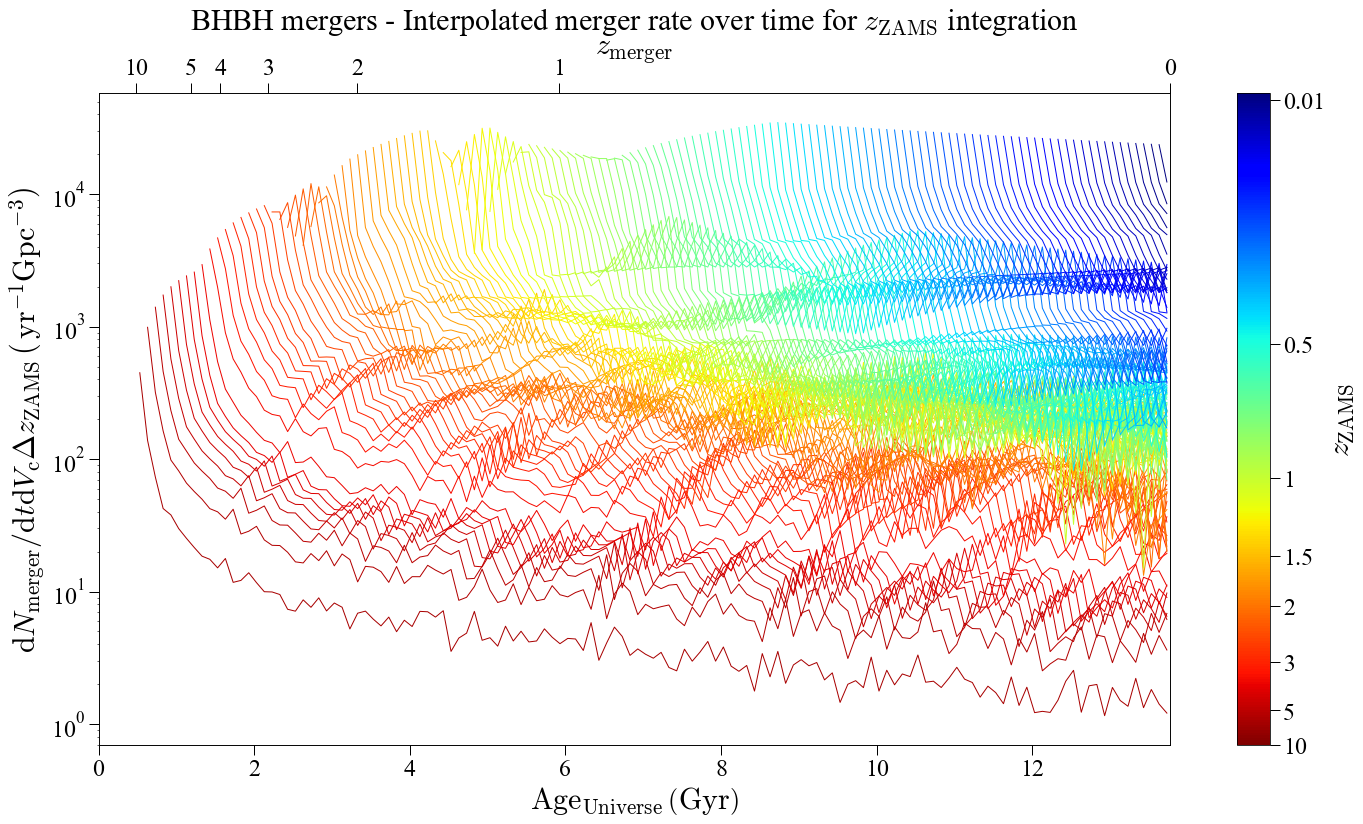

In [562]:
fig, ax = plt.subplots(figsize=(24,12))
plot_redshifts = mergerrates.ip_redshift_arr[::-1]
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
#plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [age/10 for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for mrate_array, color in zip(mergerrates._ip_dz_dage_mrates_arr, plot_colors):
    stop_i = next((i for i, x in enumerate(age_bin_centers) if x > cosmo.age(0).value), -1)
    start_i = next((i for i, x in enumerate(mrate_array) if x > 0), 0)
    ax.plot(age_bin_centers[start_i:stop_i], mrate_array[start_i:stop_i]/y_norm, color=color, alpha=1, ls='-', lw=1)    
    #ax.stairs(mrate_array, age_bin_edges, color=color, lw=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over time for $z_\mathrm{{ZAMS}}$ integration')
ax.invert_xaxis()
ax.set_xlim(0, cosmo.age(0).value)

ax.set_yscale('log')
#ax.set_ylim(1e-2, 2e3)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, cosmo.age(0).value)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

sm = cm.ScalarMappable(cmap=cm.jet_r, norm=plt.Normalize(vmin=cosmo.age(10).value, vmax=cosmo.age(0).value))
cb = fig.colorbar(sm)
redshift_ticks = [10, 5, 3, 2, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

In [563]:
mergerrates._set_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


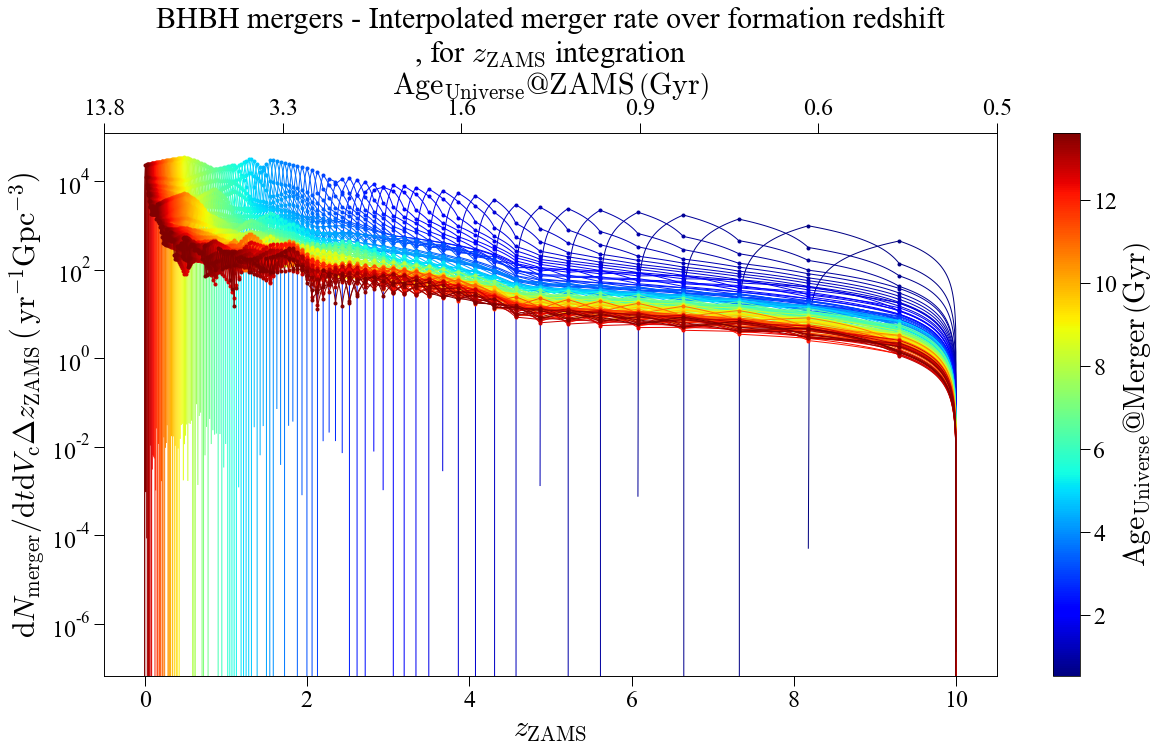

In [564]:
fig, ax = plt.subplots(figsize=(20,10))
plot_linestyles = ['-', '--', ':']
plot_linewidhts = [3, 2, 1]
plot_markerstyles = ['o', 's', '^', '*', '+', 'x']*2
plot_markersizes = [30, 20, 10]
age_bin_centers = mergerrates._physical_age_bin_centers
age_bin_edges = mergerrates._physical_age_bin_edges

plot_colors = [(age-min(age_bin_centers))/(max(age_bin_centers)-min(age_bin_centers)) for age in age_bin_centers]
plot_colors = [cm.jet(c) for c in plot_colors]

age_fits = mergerrates._per_age_redshift_fits

y_norm = 1e0
for i_age, (age, c) in enumerate(zip(age_bin_centers, plot_colors)):
    for i_redshift, redshift in enumerate(np.concatenate(([mergerrates.min_redshift], 
                                                         mergerrates.ip_redshift_arr,
                                                         [mergerrates.max_redshift]))):
        if i_redshift == 0 or i_redshift == mergerrates._ip_dz_dage_mrates_arr.shape[0]+1:
            mrate = 0
        else:
            mrate = mergerrates._ip_dz_dage_mrates_arr[i_redshift-1, i_age]
        ax.plot(redshift, mrate/y_norm, c=c, marker='o', markersize=3)
        try:
            z0, z1, slope, intercept = age_fits[i_age, i_redshift]
            #print(age_fits[i_age][i_redshift])
        except:
            pass
        finally:
            plot_zs = np.linspace(z0, z1, 100)
            plot_rates = plot_zs*slope + intercept
            #start = next((i for i, x in enumerate(plot_rates) if x), -1)
            start = 0
            ax.plot(plot_zs, plot_rates/y_norm, c=c, lw=1)
        
ax.set_yscale('log')
#ax.set_ylim(1e-3, 5e3)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$z_\mathrm{ZAMS}$')
ax.set_xticks([0, 2, 4, 6, 8, 10])

axx2 = ax.twiny()
zticks = [0, 2, 4, 6, 8, 10]
tticks = [f'{cosmo.age(z).value:.1f}' for z in zticks]
axx2.set_xticks(zticks)
axx2.set_xticklabels(tticks)
axx2.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{ZAMS}\,\left(\mathrm{Gyr}\right)$')

sm = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=age_bin_centers.min(), vmax=age_bin_centers.max()))
cb = fig.colorbar(sm)
cb.set_label('$\\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\\left(\\mathrm{Gyr}\\right)$')

ax.set_title(f'{merger_class} mergers - Interpolated merger rate over formation redshift\n, for $z_\mathrm{{ZAMS}}$ integration')
age_bin_centers = mergerrates._physical_age_bin_centers

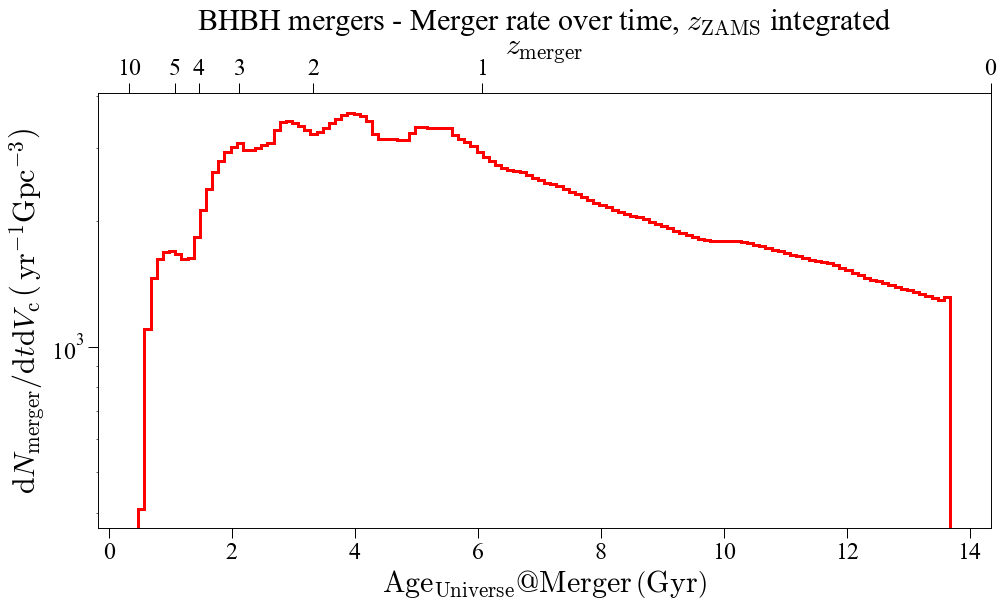

In [565]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = 'full_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [566]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])


(1314.4025, array([0.01358125, 0.00639008]))

In [567]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(3631.502, array([1.69861754]))

In [568]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [569]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [570]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [571]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [572]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(1.218839395012787, 0.9731374354586991)

In [573]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

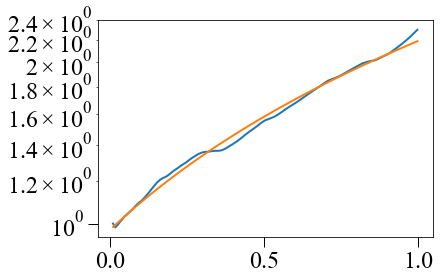

In [574]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
plt.yscale('log')
#plt.ylim(6, 200)

In [575]:
bhbh_mrates = mergerrates.mrate_arr
bhbh_edges = mergerrates._physical_age_bin_edges

In [576]:
np.save(model_id+'_bhbh_mrates_full.npy', bhbh_mrates)
np.save(model_id+'_bhbh_edges_full.npy', bhbh_edges)

In [577]:
full_merger_df = mergerrates.merger_df.copy()

## $m\leq10$

In [782]:
mergerrates.merger_df = full_merger_df[full_merger_df.Mass_PostSN1 <= 10.0].copy()

In [783]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [784]:
mergerrates._set_bins(time_resolution)

In [785]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    lowedge_i = next((i for i, x in enumerate(mergerrates._physical_redshift_bin_edges) if x <= redshift), None)
    if lowedge_i is None:
        lowedge = 0.0
        upedge = mergerrates._physical_redshift_bin_edges[-1]
    elif lowedge_i == 0:
        lowedge = mergerrates._physical_redshift_bin_edges[1]
        upedge = 10
    else:
        lowedge = mergerrates._physical_redshift_bin_edges[lowedge_i]
        upedge = mergerrates._physical_redshift_bin_edges[lowedge_i-1]        
    mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'] = (lowedge, upedge)
    #dz_zams = upedge - lowedge
    #print(redshift, lowedge, upedge, dz_zams, 
#          mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges']
#         )

In [786]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [787]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [788]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

In [789]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [790]:
mergerrates._set_dz_dpopage_mrates_arr()

In [791]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [792]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [793]:
mergerrates._set_dage_mrates_arr()

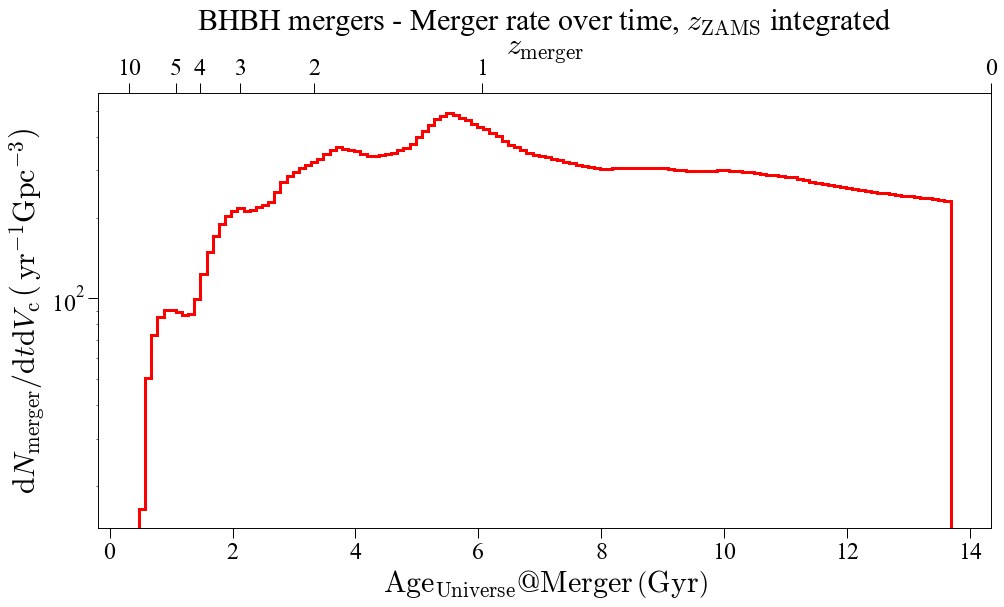

In [794]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = 'to10_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [795]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(231.04721, array([0.01358125, 0.00639008]))

In [796]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(489.82336, array([1.11574716]))

In [797]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [798]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [799]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [800]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.6931444830002602, 1.0154828296276661)

In [801]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

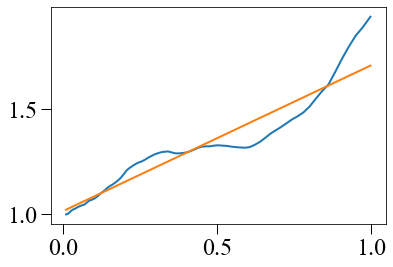

In [802]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [803]:
bhbh_mrates = mergerrates.mrate_arr
bhbh_edges = mergerrates._physical_age_bin_edges

In [804]:
np.save(model_id+'_bhbh_mrates_to10.npy', bhbh_mrates)
np.save(model_id+'_bhbh_edges_to10.npy', bhbh_edges)

## $10<m\leq20$

In [708]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 10.0) & (full_merger_df.Mass_PostSN1 <= 20.0)].copy()

In [709]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [710]:
mergerrates._set_bins(time_resolution)

In [711]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    lowedge_i = next((i for i, x in enumerate(mergerrates._physical_redshift_bin_edges) if x <= redshift), None)
    if lowedge_i is None:
        lowedge = 0.0
        upedge = mergerrates._physical_redshift_bin_edges[-1]
    elif lowedge_i == 0:
        lowedge = mergerrates._physical_redshift_bin_edges[1]
        upedge = 10
    else:
        lowedge = mergerrates._physical_redshift_bin_edges[lowedge_i]
        upedge = mergerrates._physical_redshift_bin_edges[lowedge_i-1]        
    mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'] = (lowedge, upedge)
    #dz_zams = upedge - lowedge
    #print(redshift, lowedge, upedge, dz_zams, 
#          mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges']
#         )

In [712]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [713]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [714]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

In [715]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [716]:
mergerrates._set_dz_dpopage_mrates_arr()

In [717]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [718]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [719]:
mergerrates._set_dage_mrates_arr()

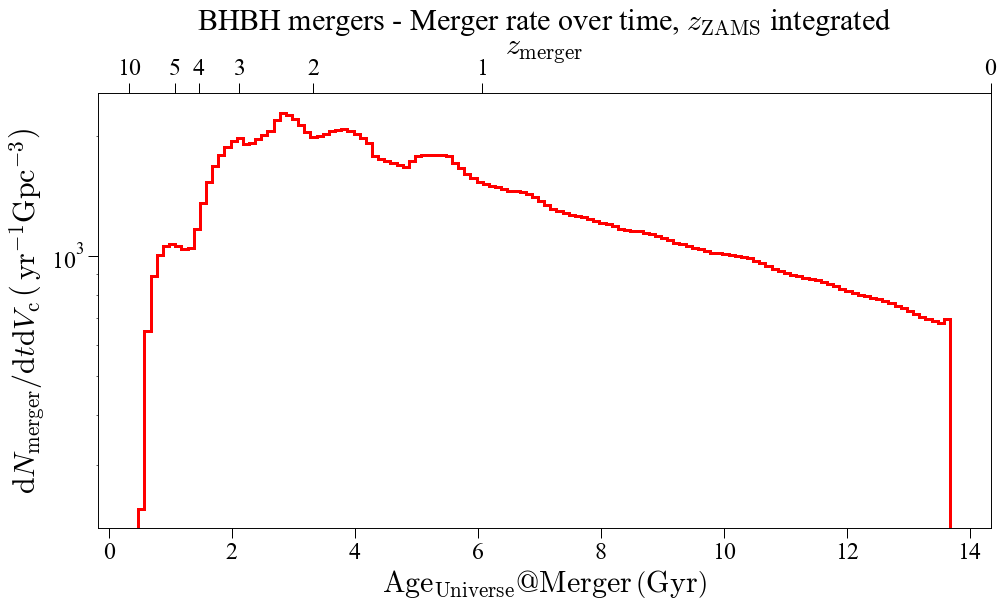

In [720]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = '10to20_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [721]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(694.71246, array([0.01358125, 0.00639008]))

In [722]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(2276.3782, array([2.39189588]))

In [723]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [724]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [725]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [726]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [727]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(1.261258066028626, 1.009381591745408)

In [728]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

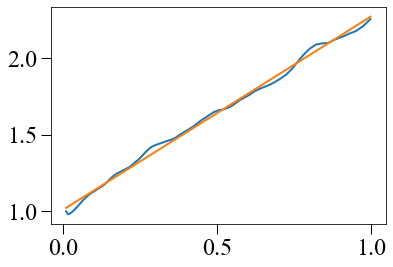

In [729]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [730]:
bhbh_mrates = mergerrates.mrate_arr
bhbh_edges = mergerrates._physical_age_bin_edges

In [731]:
np.save(model_id+'_bhbh_mrates_10to20.npy', bhbh_mrates)
np.save(model_id+'_bhbh_edges_10to20.npy', bhbh_edges)

## $20<m\leq30$

In [732]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 20.0) & (full_merger_df.Mass_PostSN1 <= 30.0)].copy()

In [733]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [734]:
mergerrates._set_bins(time_resolution)

In [735]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    lowedge_i = next((i for i, x in enumerate(mergerrates._physical_redshift_bin_edges) if x <= redshift), None)
    if lowedge_i is None:
        lowedge = 0.0
        upedge = mergerrates._physical_redshift_bin_edges[-1]
    elif lowedge_i == 0:
        lowedge = mergerrates._physical_redshift_bin_edges[1]
        upedge = 10
    else:
        lowedge = mergerrates._physical_redshift_bin_edges[lowedge_i]
        upedge = mergerrates._physical_redshift_bin_edges[lowedge_i-1]        
    mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'] = (lowedge, upedge)
    #dz_zams = upedge - lowedge
    #print(redshift, lowedge, upedge, dz_zams, 
#          mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges']
#         )

In [736]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [737]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [738]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

In [739]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [740]:
mergerrates._set_dz_dpopage_mrates_arr()

In [741]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [742]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [743]:
mergerrates._set_dage_mrates_arr()

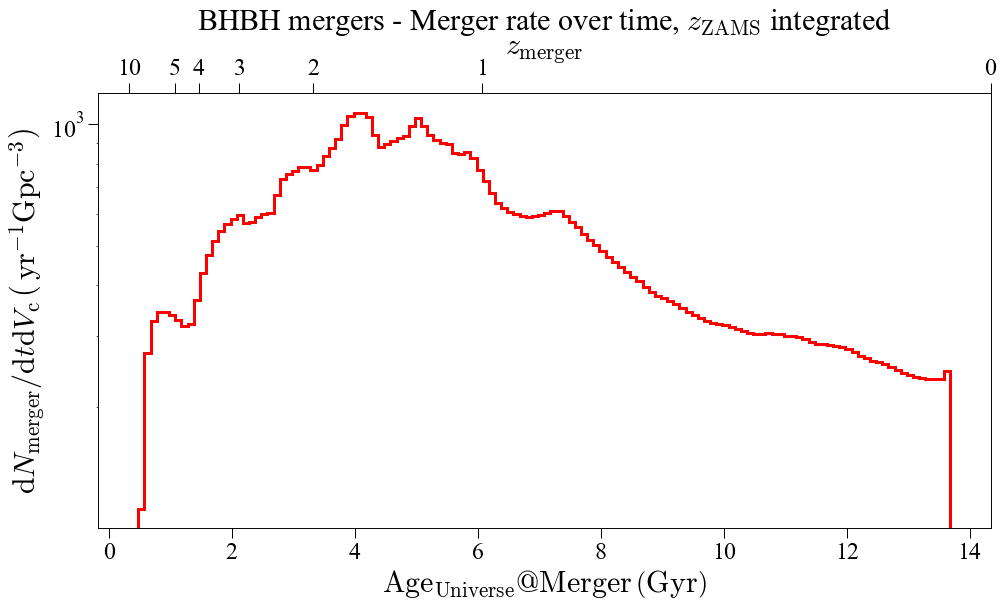

In [744]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = '20to30_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [745]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(245.20912, array([0.01358125, 0.00639008]))

In [746]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(1066.3953, array([1.65139413]))

In [747]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [748]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [749]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [750]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [751]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(2.1153018663912966, 0.757113822296851)

In [752]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

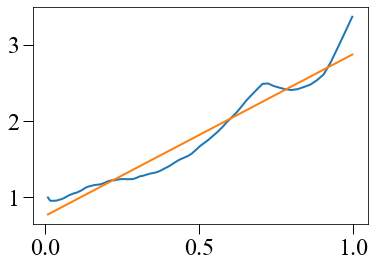

In [753]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [754]:
bhbh_mrates = mergerrates.mrate_arr
bhbh_edges = mergerrates._physical_age_bin_edges

In [755]:
np.save(model_id+'_bhbh_mrates_20to30.npy', bhbh_mrates)
np.save(model_id+'_bhbh_edges_20to30.npy', bhbh_edges)

## $m>30$

In [756]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 30.0)].copy()

In [757]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [808]:
mergerrates._set_bins(time_resolution=1)

In [809]:
for redshift in mergerrates.sample_redshift_feh_bins_dict:
    lowedge_i = next((i for i, x in enumerate(mergerrates._physical_redshift_bin_edges) if x <= redshift), None)
    if lowedge_i is None:
        lowedge = 0.0
        upedge = mergerrates._physical_redshift_bin_edges[-1]
    elif lowedge_i == 0:
        lowedge = mergerrates._physical_redshift_bin_edges[1]
        upedge = 10
    else:
        lowedge = mergerrates._physical_redshift_bin_edges[lowedge_i]
        upedge = mergerrates._physical_redshift_bin_edges[lowedge_i-1]        
    mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges'] = (lowedge, upedge)
    #dz_zams = upedge - lowedge
    #print(redshift, lowedge, upedge, dz_zams, 
#          mergerrates.sample_redshift_feh_bins_dict[redshift]['redshift_bin_edges']
#         )

In [810]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [811]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [812]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

In [813]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [814]:
mergerrates._set_dz_dpopage_mrates_arr()

In [815]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [816]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [817]:
mergerrates._set_dage_mrates_arr()

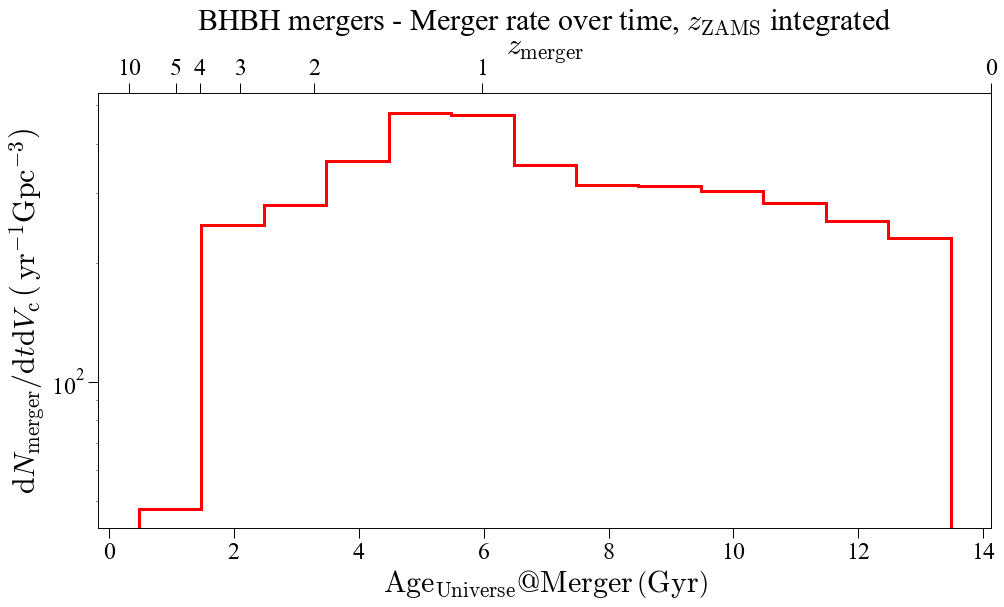

In [818]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = '30on_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [819]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(230.61522, array([0.09791146, 0.02084678]))

In [820]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(477.5004, array([1.44116824]))

In [771]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [772]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [773]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [774]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [775]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.32763125970989015, 1.098685177726141)

In [776]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

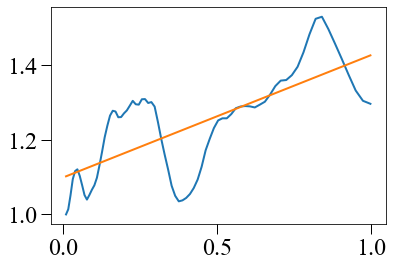

In [777]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [778]:
bhbh_mrates = mergerrates.mrate_arr
bhbh_edges = mergerrates._physical_age_bin_edges

In [779]:
np.save(model_id+'_bhbh_mrates_30on.npy', bhbh_mrates)
np.save(model_id+'_bhbh_edges_30on.npy', bhbh_edges)

## Mass ranges

In [805]:
bhbh_mrates_to10 = np.load(model_id+'_bhbh_mrates_to10.npy')
bhbh_edges_to10 = np.load(model_id+'_bhbh_edges_to10.npy')
bhbh_mrates_10to20 = np.load(model_id+'_bhbh_mrates_10to20.npy')
bhbh_edges_10to20 = np.load(model_id+'_bhbh_edges_10to20.npy')
bhbh_mrates_20to30 = np.load(model_id+'_bhbh_mrates_20to30.npy')
bhbh_edges_20to30 = np.load(model_id+'_bhbh_edges_20to30.npy')
bhbh_mrates_30on = np.load(model_id+'_bhbh_mrates_30on.npy')
bhbh_edges_30on = np.load(model_id+'_bhbh_edges_30on.npy')

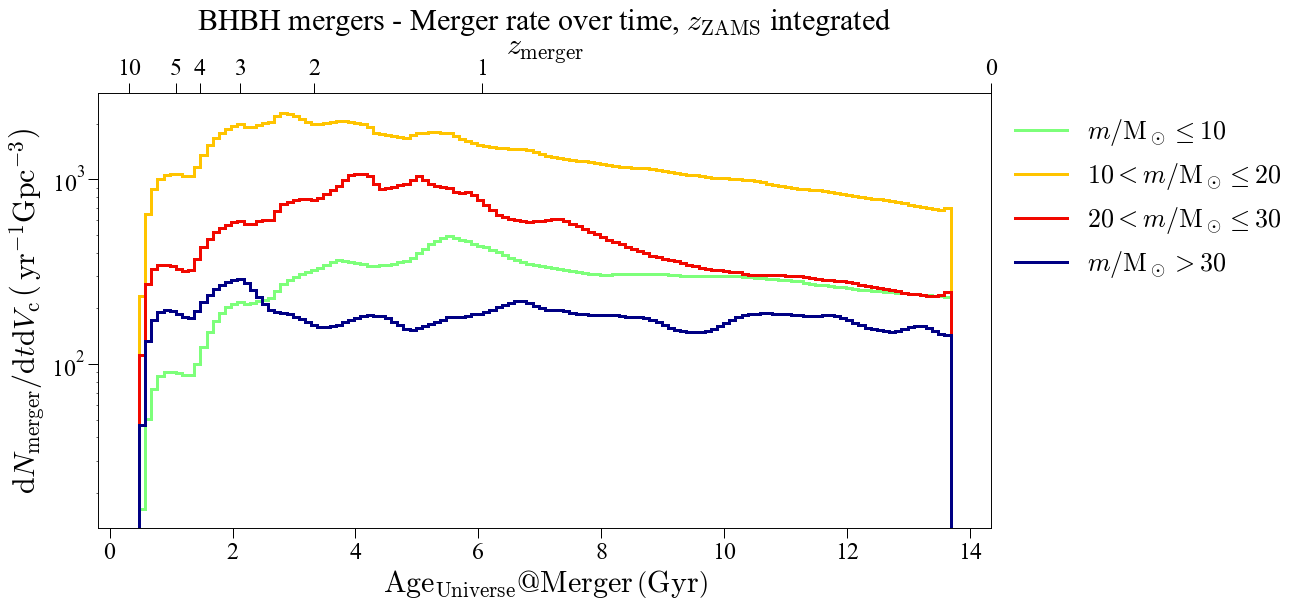

In [807]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(bhbh_mrates_to10, bhbh_edges_to10, color=cm.jet(0.5), ls='-', lw=3, label='$m/\mathrm{M}_\odot\leq10$')
ax.stairs(bhbh_mrates_10to20, bhbh_edges_10to20, color=cm.jet(0.7), ls='-', lw=3, label='$10<m/\mathrm{M}_\odot\leq20$')
ax.stairs(bhbh_mrates_20to30, bhbh_edges_20to30, color=cm.jet(0.9), ls='-', lw=3, label='$20<m/\mathrm{M}_\odot\leq30$')
ax.stairs(bhbh_mrates_30on, bhbh_edges_30on, color=cm.jet(1), ls='-', lw=3, label='$m/\mathrm{M}_\odot>30$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

fig_title = 'mbinso_bhbh_mrates'
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.png'), bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'mrates'/(fig_title+'.pdf'), bbox_inches='tight')

In [143]:
prefix = './oldmethod mrate npy files/'
bhbh_mrates_to10 = np.load(prefix+model_id+'_bhbh_mrates_to10.npy')
bhbh_edges_to10 = np.load(prefix+model_id+'_bhbh_edges_to10.npy')
bhbh_mrates_10to20 = np.load(prefix+model_id+'_bhbh_mrates_10to20.npy')
bhbh_edges_10to20 = np.load(prefix+model_id+'_bhbh_edges_10to20.npy')
bhbh_mrates_20to30 = np.load(prefix+model_id+'_bhbh_mrates_20to30.npy')
bhbh_edges_20to30 = np.load(prefix+model_id+'_bhbh_edges_20to30.npy')
bhbh_mrates_30on = np.load(prefix+model_id+'_bhbh_mrates_30on.npy')
bhbh_edges_30on = np.load(prefix+model_id+'_bhbh_edges_30on.npy')

Text(0.5, 1.0, 'BHBH mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

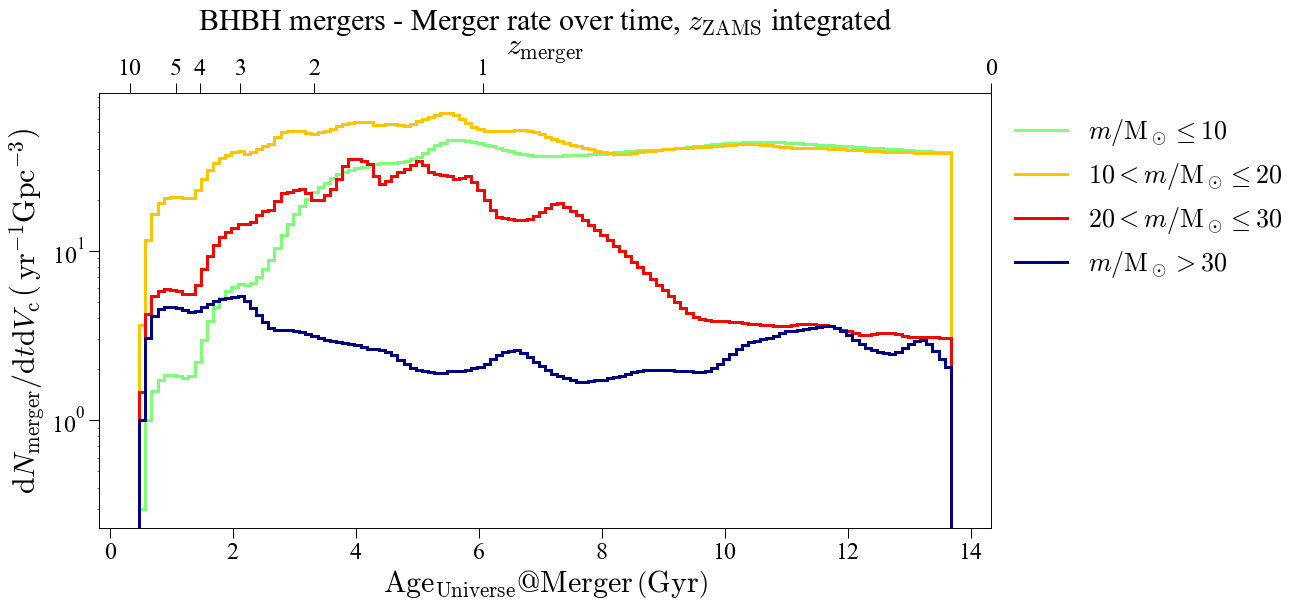

In [144]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(bhbh_mrates_to10, bhbh_edges_to10, color=cm.jet(0.5), ls='-', lw=3, label='$m/\mathrm{M}_\odot\leq10$')
ax.stairs(bhbh_mrates_10to20, bhbh_edges_10to20, color=cm.jet(0.7), ls='-', lw=3, label='$10<m/\mathrm{M}_\odot\leq20$')
ax.stairs(bhbh_mrates_20to30, bhbh_edges_20to30, color=cm.jet(0.9), ls='-', lw=3, label='$20<m/\mathrm{M}_\odot\leq30$')
ax.stairs(bhbh_mrates_30on, bhbh_edges_30on, color=cm.jet(1), ls='-', lw=3, label='$m/\mathrm{M}_\odot>30$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

# BHNS Mergers

In [901]:
merger_class = 'BHNS'
time_resolution = 0.1
mergerrates.set_merger_df(merger_class)

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df.Coalescence_Time = self.merger_df.Coalescence_Time / 1e9  # yr -> Gyr
/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df['Age_Merger'] = self._get_merger_age(self.merger_df)
/home/lucasmdesa/Documents/Compact Merger Popul

In [902]:
mergerrates._set_bins(time_resolution)

In [903]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [904]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [905]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

Text(0.5, 0, '$z_\\mathrm{merger}$')

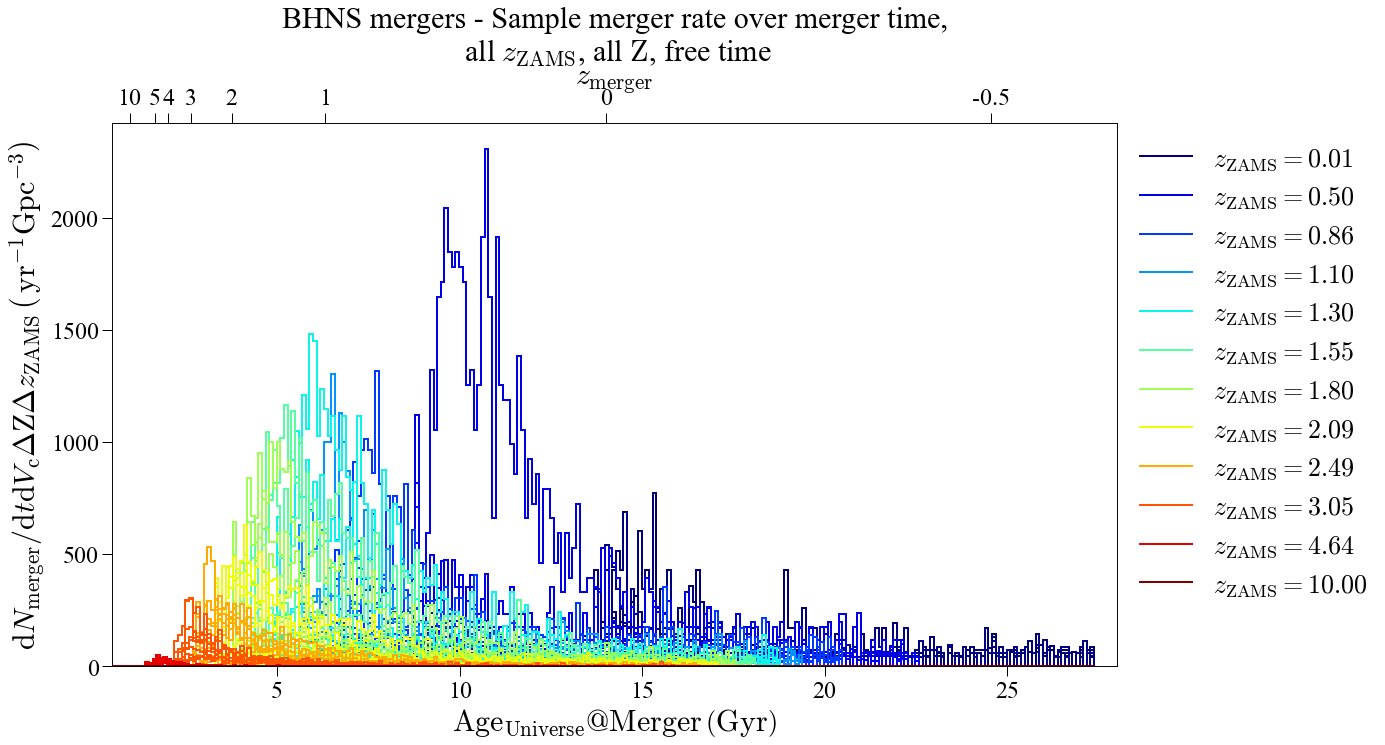

In [906]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':', '.-']*3
plot_alphas = np.linspace(0.2, 1, 10)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i_redshift, (redshift, color) in enumerate(zip(plot_redshifts, plot_colors)):
    for i_feh, feh in enumerate(mergerrates.sample_feh_arr[i_redshift]):
        age_bin_heights = mergerrates._dz_dfeh_dage_mrates_arr[i_redshift, i_feh]
        if i_feh == 0:
            label = f'$z_\mathrm{{ZAMS}}={redshift:.2f}$'
        else:
            label = None
        ax.stairs(age_bin_heights/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=label, lw=2)    
        #ax.plot(age_bin_centers, age_bin_heights/y_norm, color=color, alpha=1, ls='-', label=label, lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#ax.set_yscale('log')
ax.set_xlim(0, 28)
ax.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
axx2 = ax.twiny()
axx2.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
zs = [-0.5, 0, 1, 2, 3, 4, 5, 10]
ts = [cosmo.lookback_time(np.inf).value-cosmo.lookback_time(z).value for z in zs]
axx2.set_xlim(0, 28)
axx2.set_xticks(ts)
axx2.set_xticklabels(zs)
axx2.set_xlabel(r'$z_\mathrm{merger}$')

In [890]:
mergerrates._set_dz_dage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$')

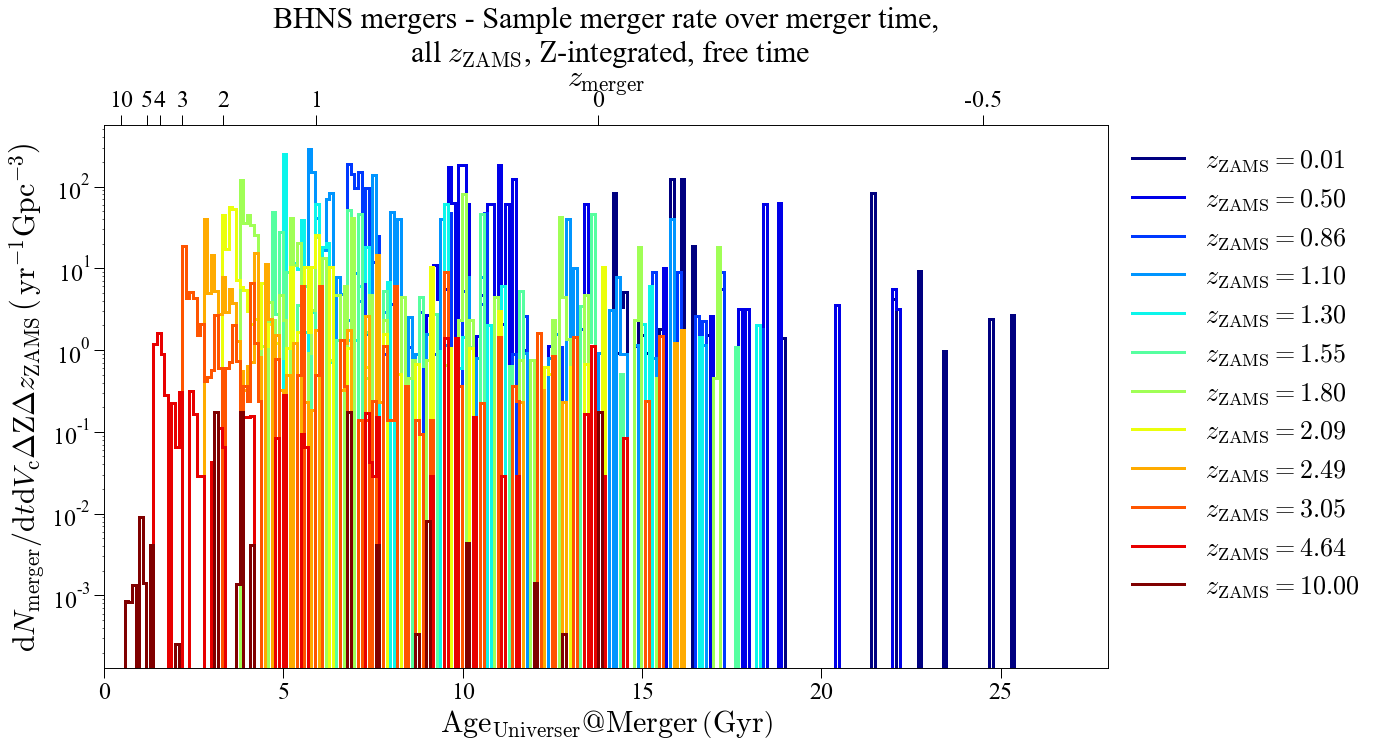

In [891]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=3)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universer}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 28)

#ax.set_ylim(1e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 28)
zticks = [10, 5, 4, 3, 2, 1, 0, -0.5]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

In [892]:
mergerrates._set_dz_dpopage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$ if $z_\\mathrm{ZAMS}=10$')

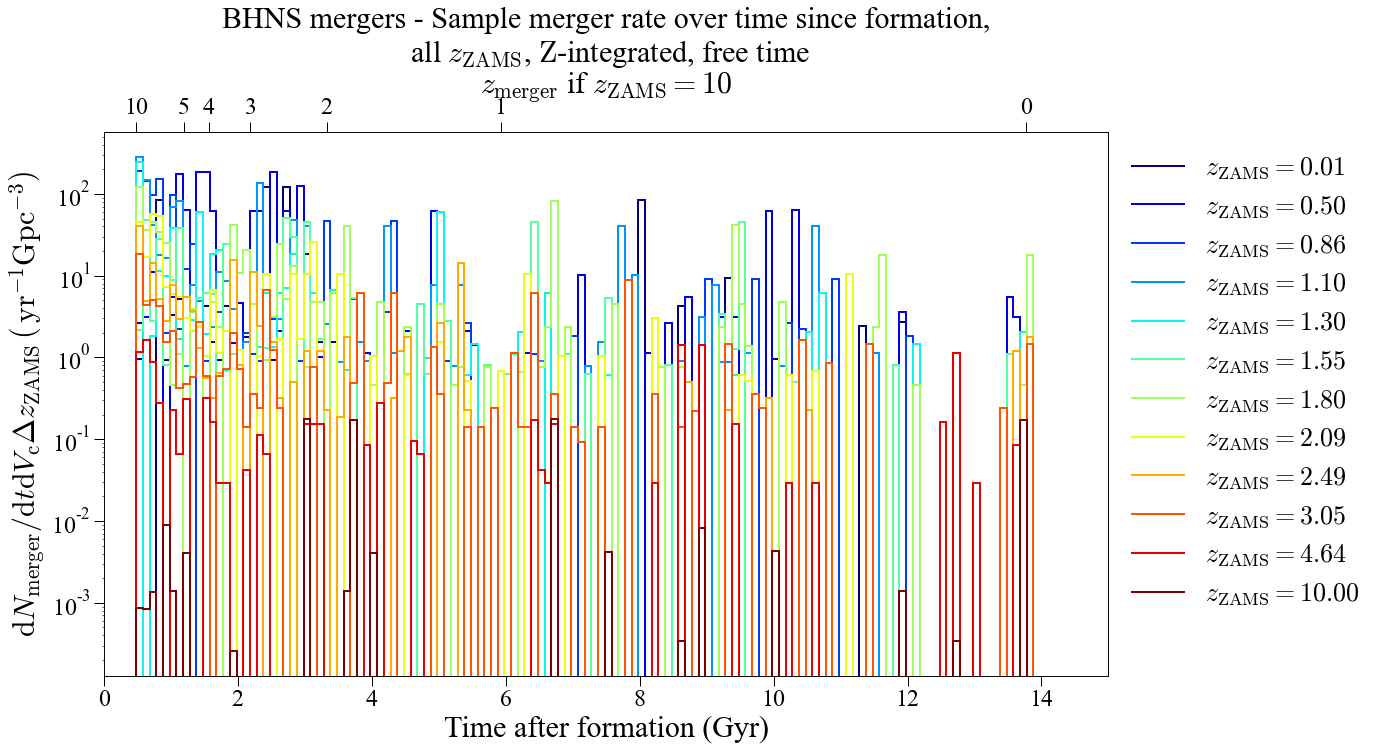

In [893]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

cmap = cm.jet
min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cmap(c) for c in plot_colors]
plot_colors = [cmap(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i, (redshift, redshift_mrate_array, color) in enumerate(zip(plot_redshifts, mergerrates._dz_dpopage_mrates_arr, plot_colors)):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel('Time after formation (Gyr)')
ax.set_title(f'{merger_class} mergers - Sample merger rate over time since formation,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
#ax.set_ylim(5e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

In [894]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$ if $z_\\mathrm{ZAMS}=10$')

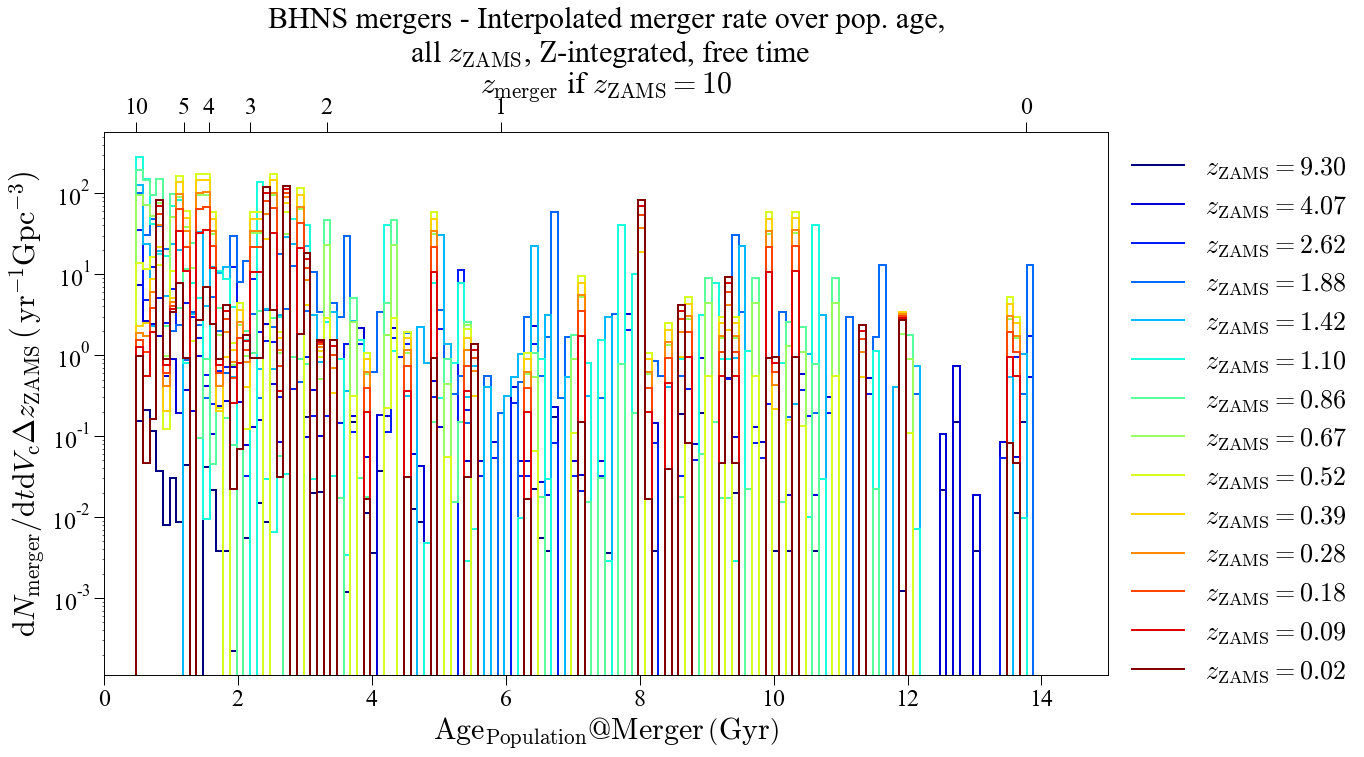

In [895]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.ip_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts[::10], mergerrates._ip_dz_dpopage_mrates_arr[::10], plot_colors[::10]):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Population}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over pop. age,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
#ax.set_ylim(5e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

In [896]:
mergerrates._set_ip_dz_dage_mrates_arr()

[Text(13.768899116929322, 1, '0'),
 Text(5.922228427916887, 1, '1'),
 Text(3.3267847092936784, 1, '2'),
 Text(2.1782808536748703, 1, '3'),
 Text(1.5628233511789464, 1, '4'),
 Text(1.1900242903826443, 1, '5'),
 Text(0.479174188974518, 1, '10')]

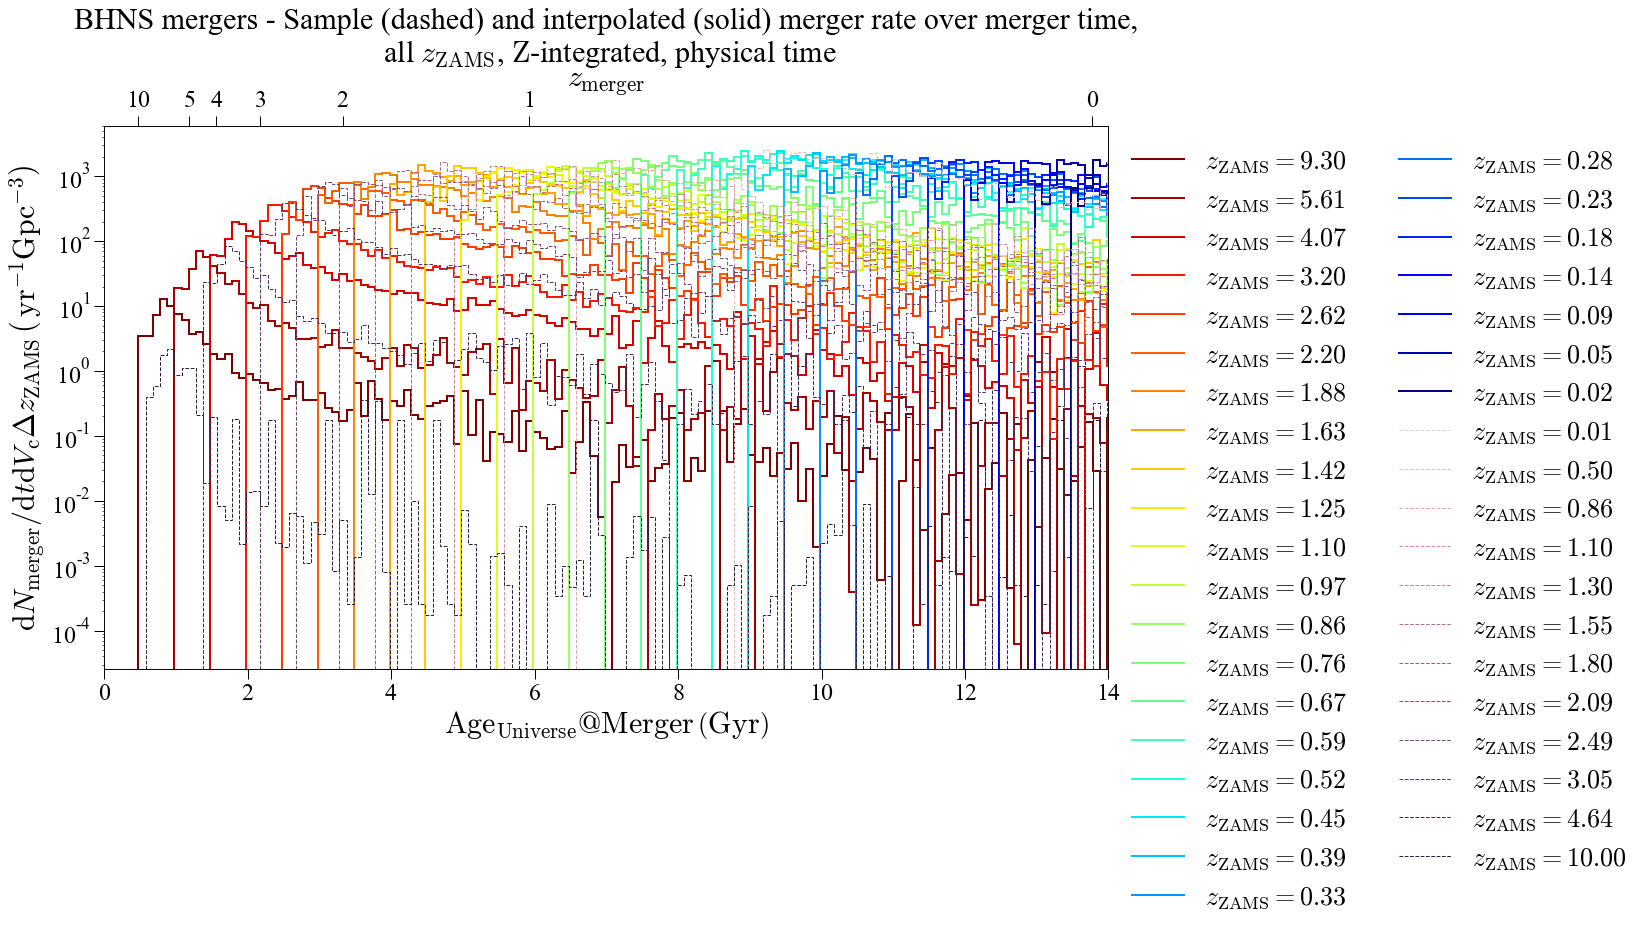

In [842]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr
ip_plot_redshifts = mergerrates.ip_redshift_arr

#min_color = 0
#plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in ip_plot_redshifts][::-1]
#plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
#plot_colors = [cm.jet(c) for c in plot_colors]
ip_plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(ip_plot_redshifts))[::-1]]
plot_colors = [cm_cubehelix(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(mergerrates.ip_redshift_arr[::5], mergerrates._ip_dz_dage_mrates_arr[::5], ip_plot_colors[::5]):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    

for redshift, redshift_mrate_array, color in zip(mergerrates.sample_redshift_arr, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='--', lw=1, label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$')    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=2)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample (dashed) and interpolated (solid) merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, physical time')
#ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_yscale('log')
#ax.set_ylim(1e-3, 2e1)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, 14)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

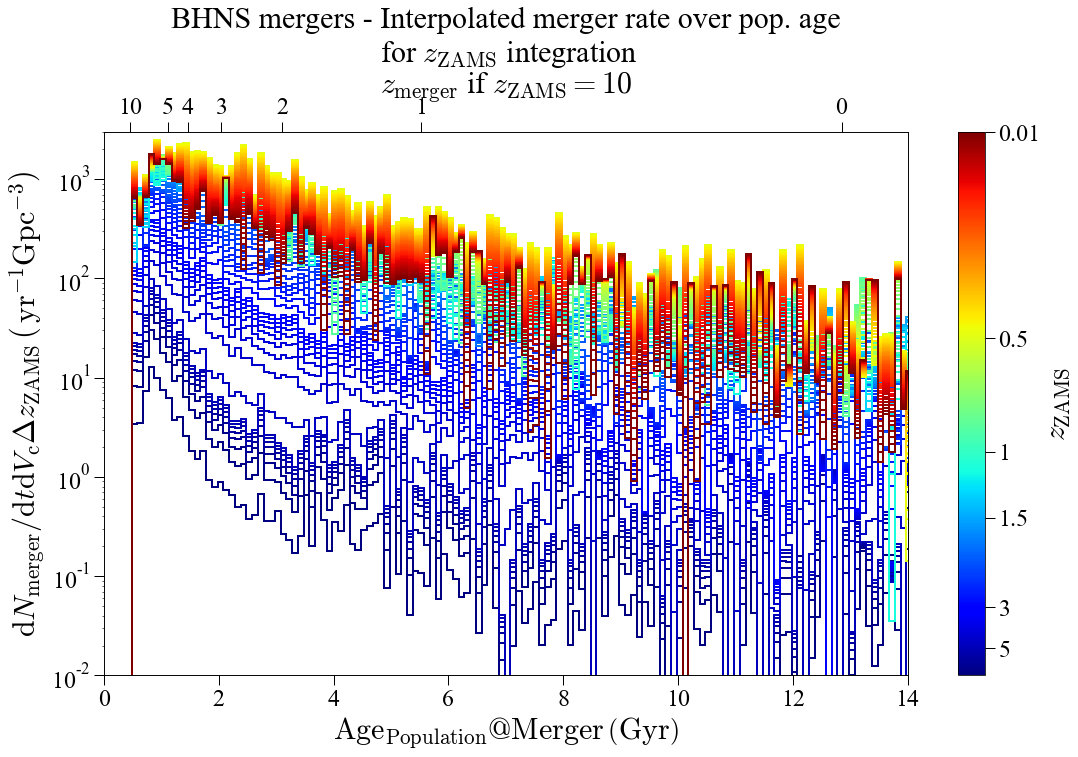

In [845]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.ip_redshift_arr
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._ip_dz_dpopage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Population}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over pop. age\n for $z_\mathrm{{ZAMS}}$ integration')
#ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_ylim(1e-2, 3e3)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

sm = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=plot_ages.min(), vmax=plot_ages.max()))
cb = fig.colorbar(sm)
redshift_ticks = [5, 3, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

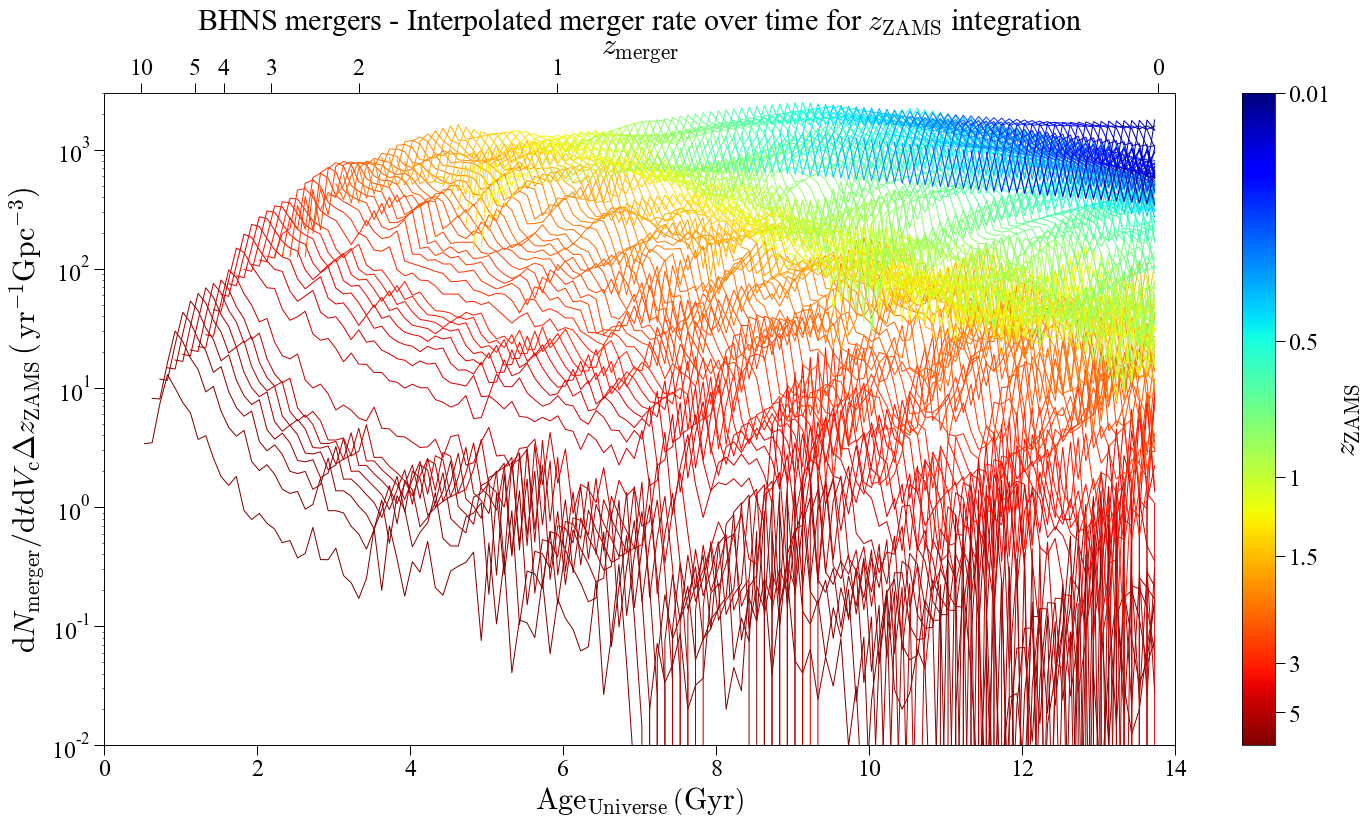

In [846]:
fig, ax = plt.subplots(figsize=(24,12))
plot_redshifts = mergerrates.ip_redshift_arr[::-1]
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for mrate_array, color in zip(mergerrates._ip_dz_dage_mrates_arr, plot_colors):
    stop_i = next((i for i, x in enumerate(age_bin_centers) if x > cosmo.age(0).value), -1)
    start_i = next((i for i, x in enumerate(mrate_array) if x > 0), 0)
    ax.plot(age_bin_centers[start_i:stop_i], mrate_array[start_i:stop_i]/y_norm, color=color, alpha=1, ls='-', lw=1)    
    #ax.stairs(mrate_array, age_bin_edges, color=color, lw=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over time for $z_\mathrm{{ZAMS}}$ integration')
ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_yscale('log')
ax.set_ylim(1e-2, 3e3)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, 14)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

sm = cm.ScalarMappable(cmap=cm.jet_r, norm=plt.Normalize(vmin=plot_ages.min(), vmax=plot_ages.max()))
cb = fig.colorbar(sm)
redshift_ticks = [5, 3, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

In [897]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

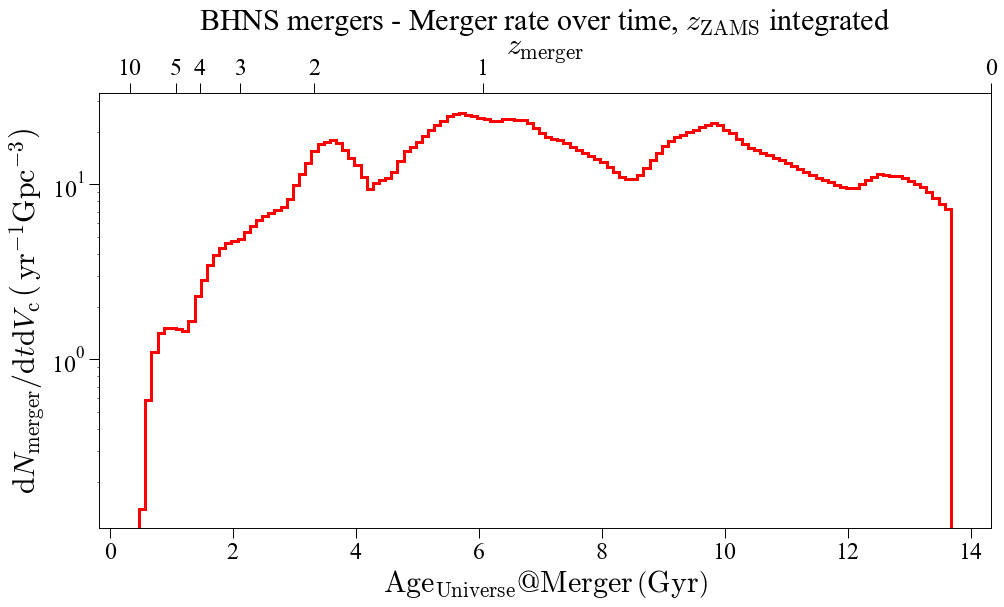

In [898]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')



In [899]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(7.2148175, array([0.01358125, 0.00639008]))

In [900]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(25.551298, array([1.0617453]))

In [851]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [852]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [853]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [854]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [855]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.8700986228053443, 1.2396773577192381)

In [856]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

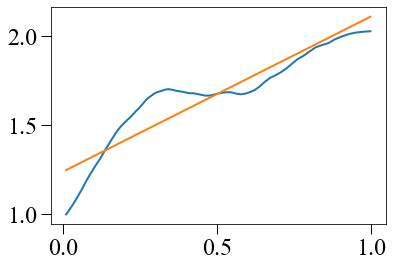

In [857]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [858]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [859]:
np.save(model_id+'_bhns_mrates_full.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_full.npy', bhns_edges)

In [860]:
full_merger_df = mergerrates.merger_df.copy()

## $m<3$

In [861]:
mergerrates.merger_df = full_merger_df[full_merger_df.Mass_PostSN1 < 3].copy()

In [862]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [863]:
mergerrates._set_bins(time_resolution)

In [877]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [878]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr  / 1e3

In [879]:
mergerrates._dz_dfeh_dage_mrates_arr = mergerrates._dz_dfeh_dage_mrates_arr / mergerrates._full_age_bin_widths

In [880]:
mergerrates._set_dz_dage_mrates_arr()

In [881]:
mergerrates._set_dz_dpopage_mrates_arr()

In [882]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [883]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [884]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

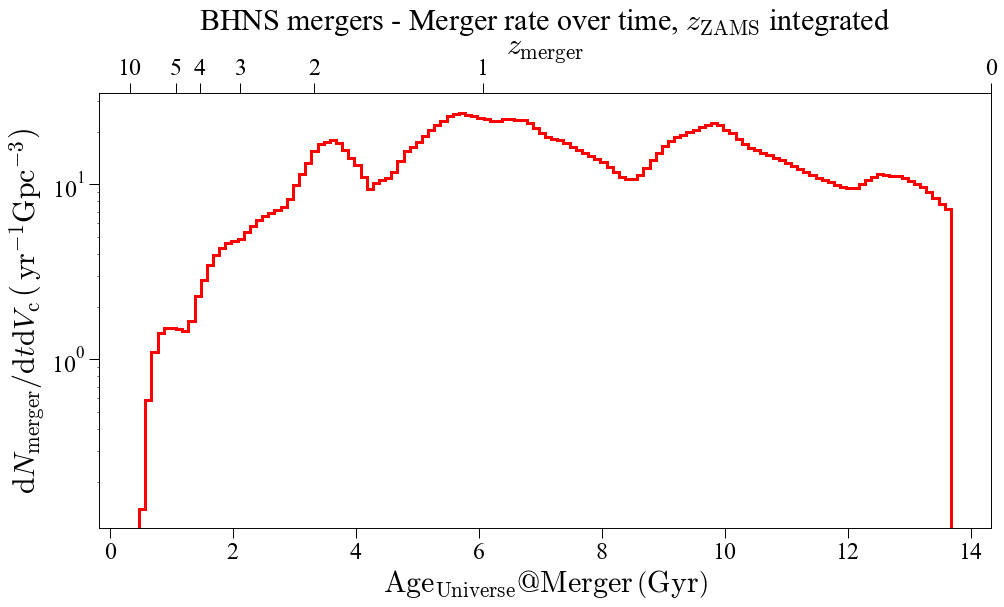

In [885]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [871]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(721.48145, array([0.01358125, 0.00639008]))

In [872]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(2555.1335, array([1.0617453]))

In [873]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [874]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [875]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [876]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [189]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(1.827467499769458, 1.3668619721014155)

In [190]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

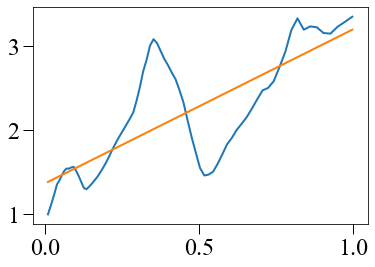

In [191]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [192]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [193]:
np.save(model_id+'_bhns_mrates_to3.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_to3.npy', bhns_edges)

## $3<m\leq5$

In [194]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 3.0) & (full_merger_df.Mass_PostSN1 <= 5.0)].copy()

In [195]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [196]:
mergerrates._set_bins(time_resolution)

In [197]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [198]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [199]:
mergerrates._set_dz_dpopage_mrates_arr()

In [200]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [201]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [202]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

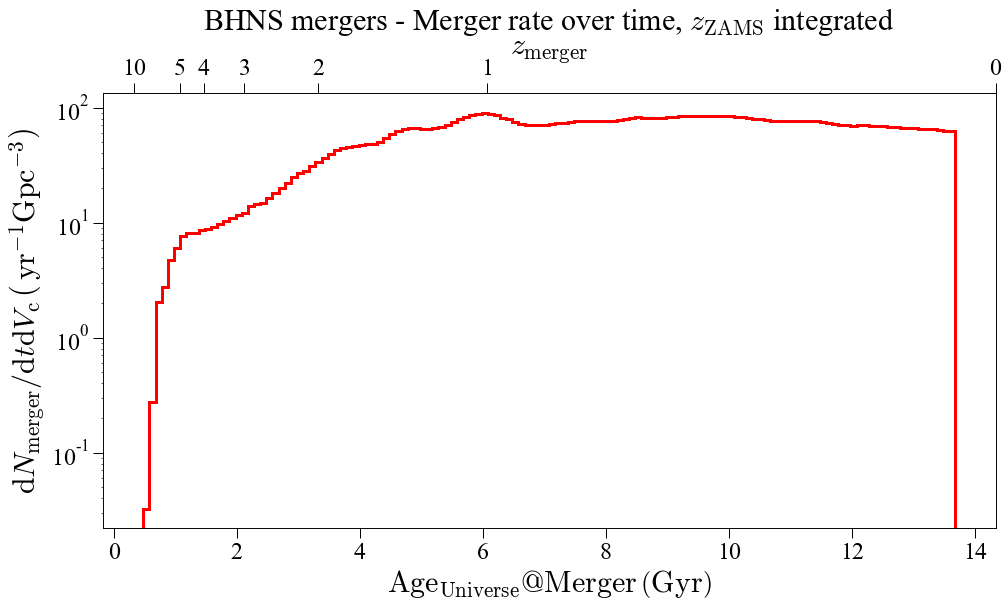

In [203]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [204]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(62.35678, array([0.01358125, 0.00639008]))

In [205]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(89.551994, array([0.98610329]))

In [206]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [207]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [208]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [209]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [210]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.19491129442094243, 1.1440505212815286)

In [211]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

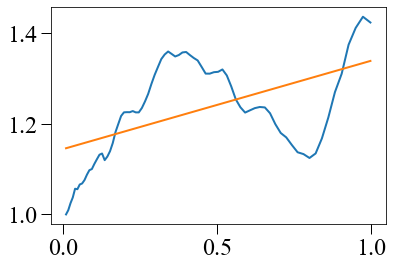

In [212]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [213]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [214]:
np.save(model_id+'_bhns_mrates_3to5.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_3to5.npy', bhns_edges)

## $5<m\leq10$

In [215]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 5.0) & (full_merger_df.Mass_PostSN1 <= 10.0)].copy()

In [216]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [217]:
mergerrates._set_bins(time_resolution)

In [218]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [219]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [220]:
mergerrates._set_dz_dpopage_mrates_arr()

In [221]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [222]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [223]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

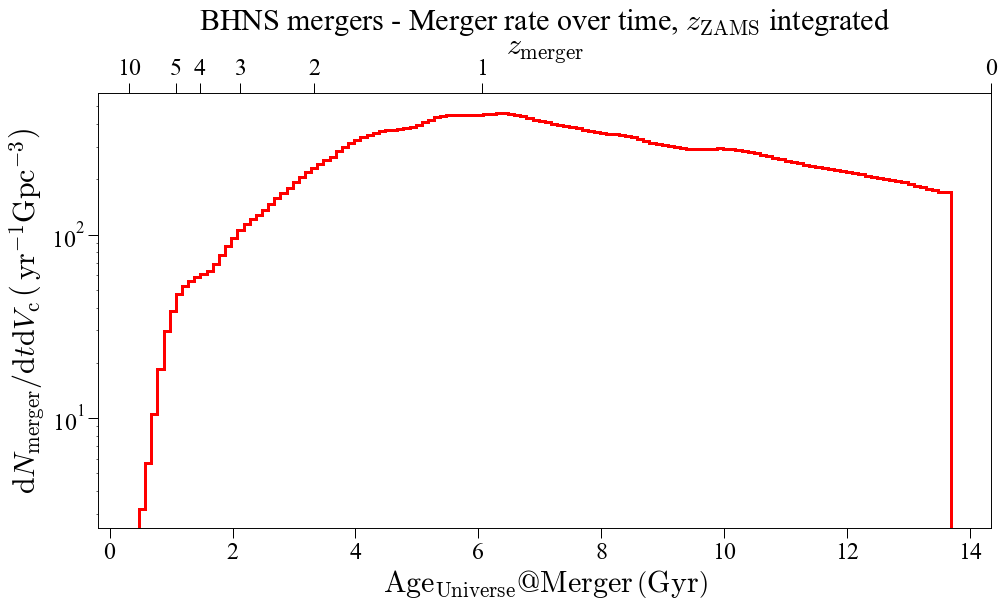

In [224]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [225]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(169.7478, array([0.01358125, 0.00639008]))

In [226]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(458.61267, array([0.91615886]))

In [227]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [228]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [229]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [230]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [231]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(1.8003786285356989, 1.0509663869203556)

In [232]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

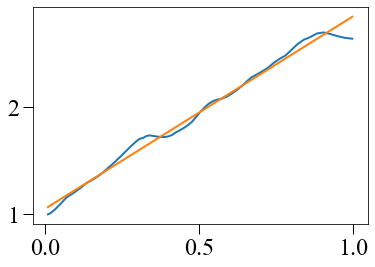

In [233]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [234]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [235]:
np.save(model_id+'_bhns_mrates_5to10.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_5to10.npy', bhns_edges)

## $10<m\leq20$

In [236]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 10.0) & (full_merger_df.Mass_PostSN1 <= 20.0)].copy()

In [237]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [238]:
mergerrates._set_bins(time_resolution)

In [239]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [240]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [241]:
mergerrates._set_dz_dpopage_mrates_arr()

In [242]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [243]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [244]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

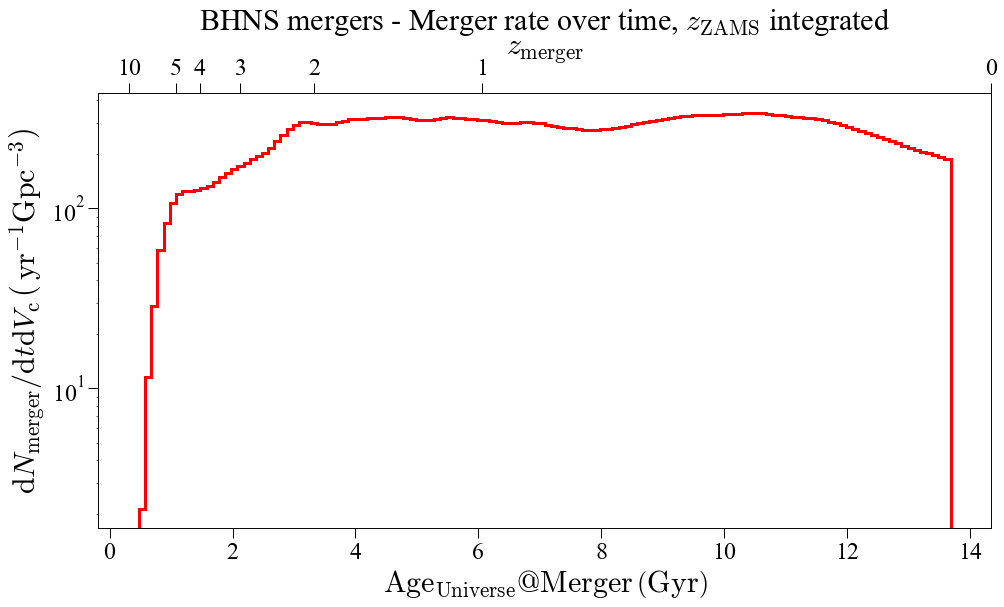

In [245]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [246]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(188.19475, array([0.01358125, 0.00639008]))

In [247]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(338.01932, array([0.28186936]))

In [248]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [249]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [250]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [251]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [252]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.2556655670955267, 1.4459995621062751)

In [253]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

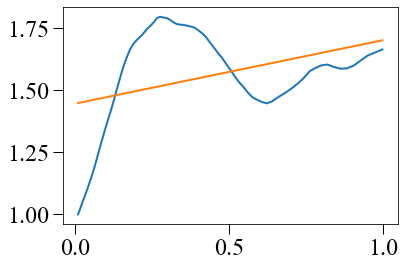

In [254]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [255]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [256]:
np.save(model_id+'_bhns_mrates_10to20.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_10to20.npy', bhns_edges)

## $20<m$

In [257]:
mergerrates.merger_df = full_merger_df[(full_merger_df.Mass_PostSN1 > 20.0)].copy()

In [258]:
mergerrates.sample_redshift_feh_bins_dict = dict()

In [259]:
mergerrates._set_bins(time_resolution)

In [260]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

In [261]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


In [262]:
mergerrates._set_dz_dpopage_mrates_arr()

In [263]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

In [264]:
mergerrates._set_ip_dz_dage_mrates_arr()

In [265]:
mergerrates._set_dage_mrates_arr()

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

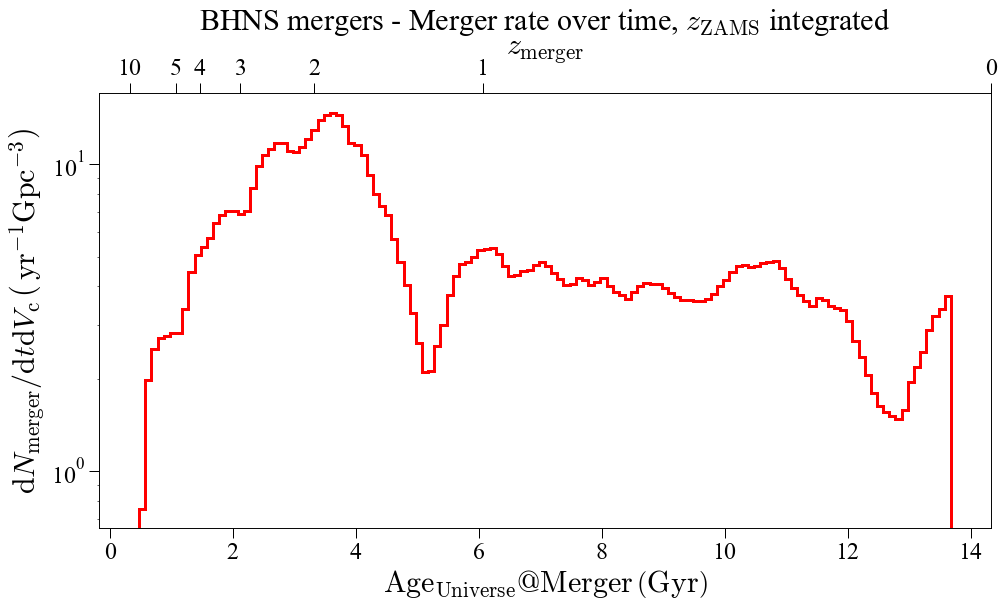

In [266]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [267]:
bhns_mrates = mergerrates.mrate_arr
bhns_edges = mergerrates._physical_age_bin_edges

In [268]:
np.save(model_id+'_bhns_mrates_20on.npy', bhns_mrates)
np.save(model_id+'_bhns_edges_20on.npy', bhns_edges)

## Mass ranges

In [269]:
bhns_mrates_to3 = np.load(model_id+'_bhns_mrates_to3.npy')
bhns_edges_to3 = np.load(model_id+'_bhns_edges_to3.npy')
bhns_mrates_3to5 = np.load(model_id+'_bhns_mrates_3to5.npy')
bhns_edges_3to5 = np.load(model_id+'_bhns_edges_3to5.npy')
bhns_mrates_5to10 = np.load(model_id+'_bhns_mrates_5to10.npy')
bhns_edges_5to10 = np.load(model_id+'_bhns_edges_5to10.npy')
bhns_mrates_10to20 = np.load(model_id+'_bhns_mrates_10to20.npy')
bhns_edges_10to20 = np.load(model_id+'_bhns_edges_10to20.npy')
bhns_mrates_20on = np.load(model_id+'_bhns_mrates_20on.npy')
bhns_edges_20on = np.load(model_id+'_bhns_edges_20on.npy')

Text(0.5, 1.0, 'BHNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

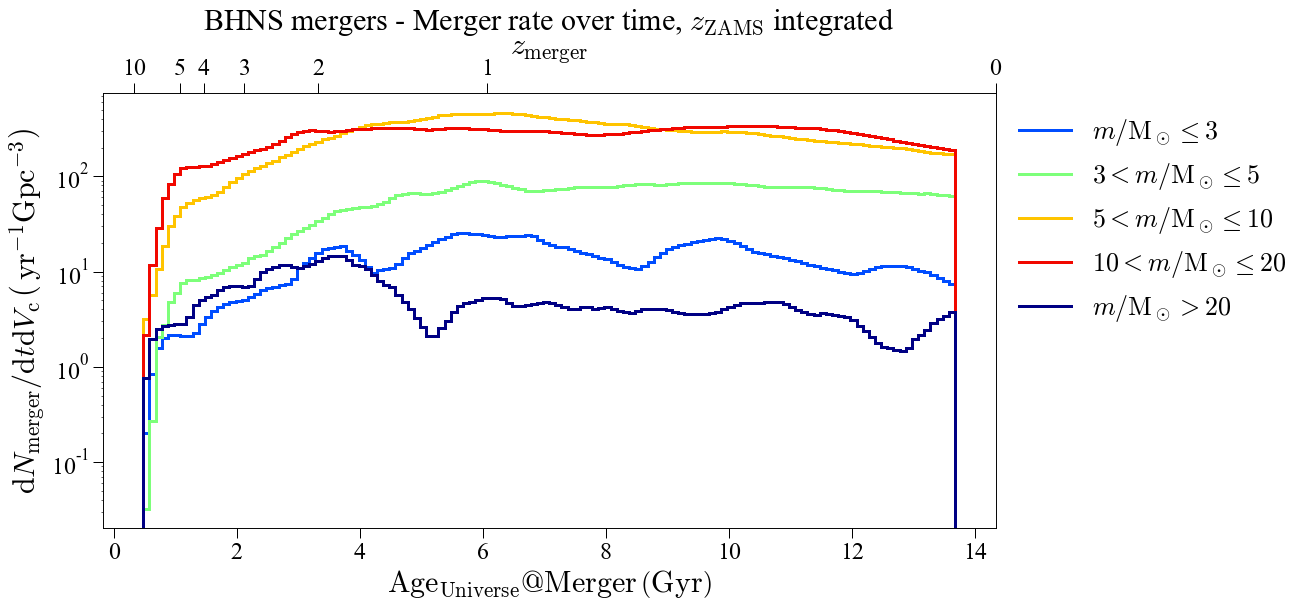

In [270]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(bhns_mrates_to3, bhns_edges_to3, color=cm.jet(0.2), ls='-', lw=3, label='$m/\mathrm{M}_\odot\leq3$')
ax.stairs(bhns_mrates_3to5, bhns_edges_3to5, color=cm.jet(0.5), ls='-', lw=3, label='$3<m/\mathrm{M}_\odot\leq5$')
ax.stairs(bhns_mrates_5to10, bhns_edges_5to10, color=cm.jet(0.7), ls='-', lw=3, label='$5<m/\mathrm{M}_\odot\leq10$')
ax.stairs(bhns_mrates_10to20, bhns_edges_10to20, color=cm.jet(0.9), ls='-', lw=3, label='$10<m/\mathrm{M}_\odot\leq20$')
ax.stairs(bhns_mrates_20on, bhns_edges_20on, color=cm.jet(1), ls='-', lw=3, label='$m/\mathrm{M}_\odot>20$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

# NSNS Mergers

In [327]:
merger_class = 'NSNS'
time_resolution = 0.5
mergerrates.set_merger_df(merger_class)

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df.Coalescence_Time = self.merger_df.Coalescence_Time / 1e9  # yr -> Gyr
/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merger_df['Age_Merger'] = self._get_merger_age(self.merger_df)
/home/lucasmdesa/Documents/Compact Merger Popul

In [336]:
mergerrates._set_bins(time_resolution)

In [337]:
mergerrates._set_dz_dfeh_dage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$')

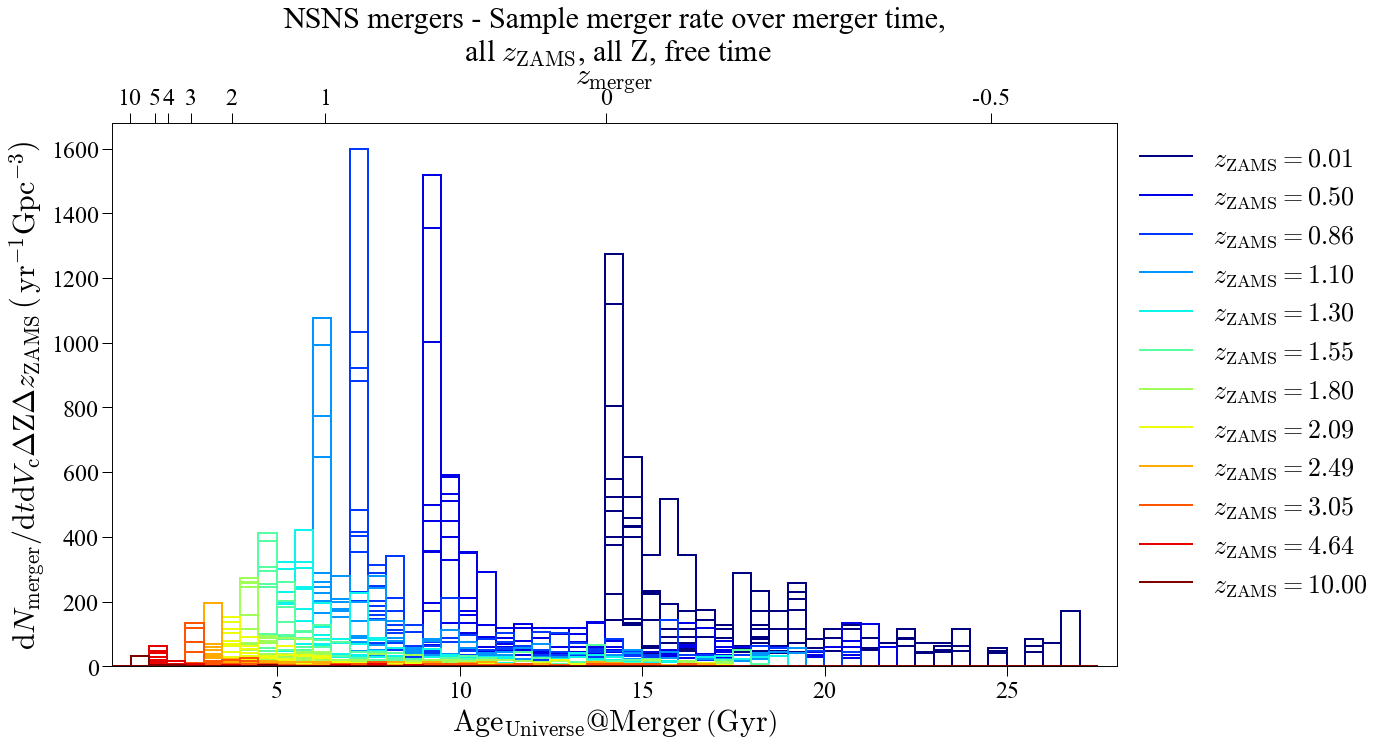

In [330]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':', '.-']*3
plot_alphas = np.linspace(0.2, 1, 10)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i_redshift, (redshift, color) in enumerate(zip(plot_redshifts, plot_colors)):
    for i_feh, feh in enumerate(mergerrates.sample_feh_arr[i_redshift]):
        age_bin_heights = mergerrates._dz_dfeh_dage_mrates_arr[i_redshift, i_feh]
        if i_feh == 0:
            label = f'$z_\mathrm{{ZAMS}}={redshift:.2f}$'
        else:
            label = None
        ax.stairs(age_bin_heights/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=label, lw=2)    
        #ax.plot(age_bin_centers, age_bin_heights/y_norm, color=color, alpha=1, ls='-', label=label, lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#ax.set_yscale('log')
ax.set_xlim(0, 28)
ax.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
axx2 = ax.twiny()
axx2.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
zs = [-0.5, 0, 1, 2, 3, 4, 5, 10]
ts = [cosmo.lookback_time(np.inf).value-cosmo.lookback_time(z).value for z in zs]
axx2.set_xlim(0, 28)
axx2.set_xticks(ts)
axx2.set_xticklabels(zs)
axx2.set_xlabel(r'$z_\mathrm{merger}$')

Text(0.5, 0, '$z_\\mathrm{merger}$')

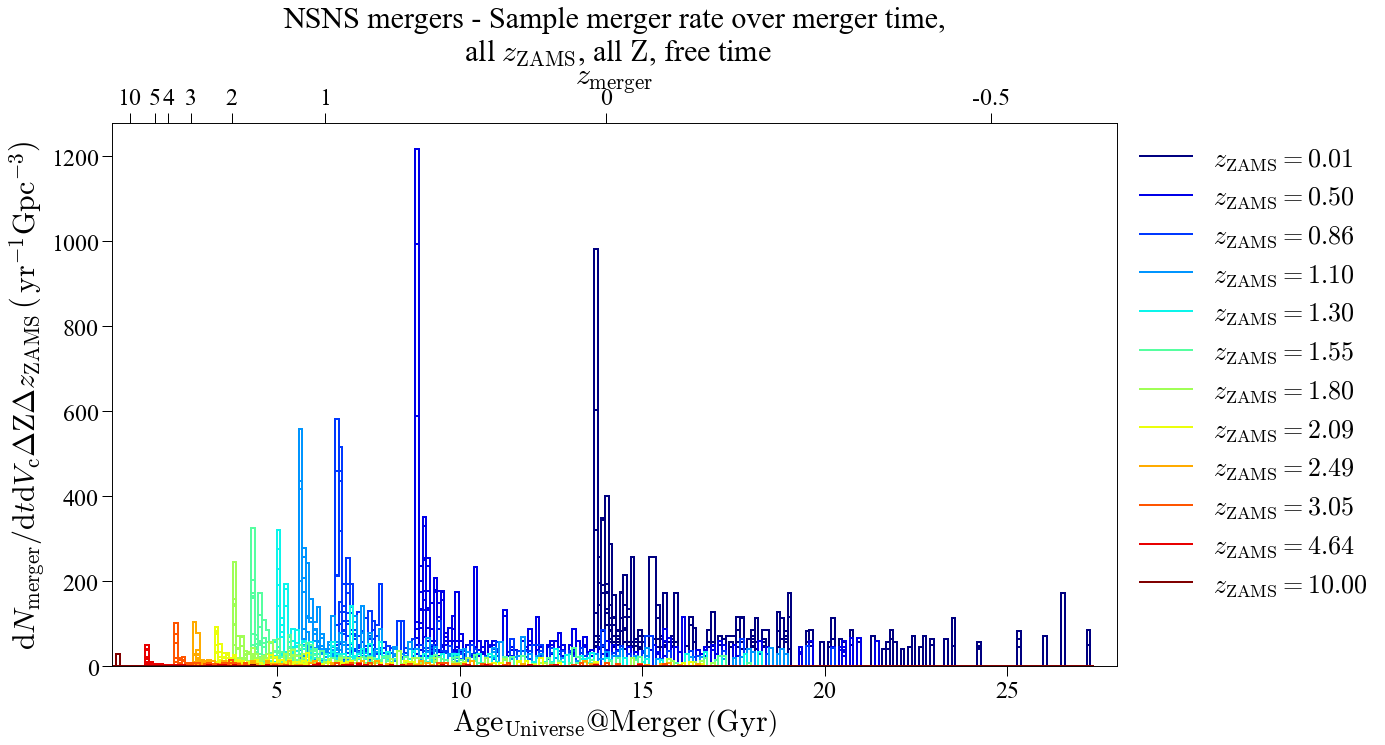

In [274]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':', '.-']*3
plot_alphas = np.linspace(0.2, 1, 10)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i_redshift, (redshift, color) in enumerate(zip(plot_redshifts, plot_colors)):
    for i_feh, feh in enumerate(mergerrates.sample_feh_arr[i_redshift]):
        age_bin_heights = mergerrates._dz_dfeh_dage_mrates_arr[i_redshift, i_feh]
        if i_feh == 0:
            label = f'$z_\mathrm{{ZAMS}}={redshift:.2f}$'
        else:
            label = None
        ax.stairs(age_bin_heights/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=label, lw=2)    
        #ax.plot(age_bin_centers, age_bin_heights/y_norm, color=color, alpha=1, ls='-', label=label, lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#ax.set_yscale('log')
ax.set_xlim(0, 28)
ax.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
axx2 = ax.twiny()
axx2.set_xlim(cosmo.lookback_time(np.inf).value-cosmo.lookback_time(10).value)#, cosmo.lookback_time(np.inf).value)
zs = [-0.5, 0, 1, 2, 3, 4, 5, 10]
ts = [cosmo.lookback_time(np.inf).value-cosmo.lookback_time(z).value for z in zs]
axx2.set_xlim(0, 28)
axx2.set_xticks(ts)
axx2.set_xticklabels(zs)
axx2.set_xlabel(r'$z_\mathrm{merger}$')

In [338]:
mergerrates._set_dz_dage_mrates_arr()

/home/lucasmdesa/Documents/Compact Merger Populations/Analysis/pc_notebooks/../../src/postprocessing.py:767: RuntimeWarning: invalid value encountered in double_scalars
  slope = (y1 - y0) / (x1 - x0)


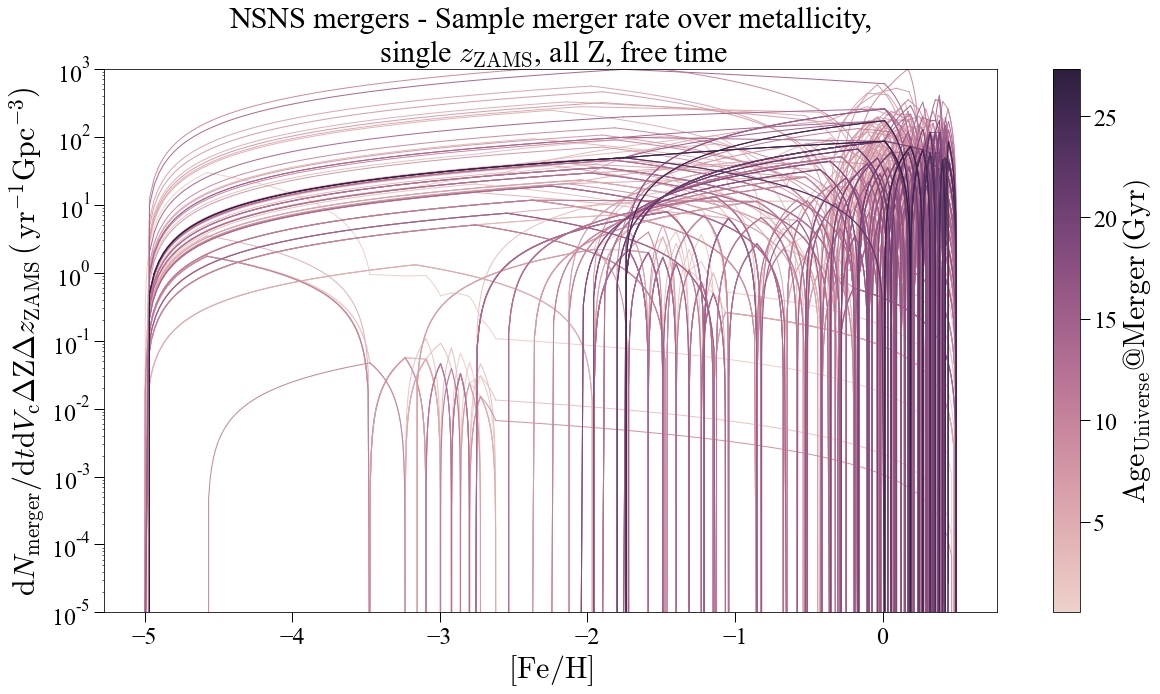

In [276]:
fig, ax = plt.subplots(figsize=(20,10))
plot_linestyles = ['-', '--', ':']
plot_linewidhts = [3, 2, 1]
plot_markerstyles = ['o', 's', '^', '*', '+', 'x', 'o', 's', '^', '*']*2
plot_linestyles = ['-', '--', ':']*4
plot_markersizes = [35, 30, 20, 10, 5]*2

age_bin_centers = mergerrates._full_age_bin_centers

plot_colors = [(age-min(age_bin_centers))/(max(age_bin_centers)-min(age_bin_centers)) for age in age_bin_centers]
plot_colors = [cm_cubehelix(c) for c in plot_colors]

age_fits = mergerrates._per_age_redshift_feh_fits
feh_redshift_age_array = mergerrates._dz_dfeh_dage_mrates_arr

y_norm = 1e0
for i_age, (age, c) in enumerate(zip(age_bin_centers, plot_colors)):
    for i_redshift, redshift in enumerate(mergerrates.sample_redshift_arr):
        for i_feh, feh in enumerate(np.concatenate(([mergerrates.min_feh],
                                                    mergerrates.sample_feh_arr[i_redshift],
                                                    [mergerrates.max_feh]))):
            if i_feh == 0 or i_feh == mergerrates.sample_feh_arr[i_redshift].shape[0]+1:
                mrate = 0
            else:
                mrate = feh_redshift_age_array[i_redshift, i_feh-1, i_age]
            ax.plot(feh, mrate/y_norm, c=c, markersize=10, alpha=1)
            try:
                feh0, feh1, slope, intercept = age_fits[i_age][i_redshift][i_feh]
                #print(feh0, feh1, slope, intercept)
                plot_fehs = np.linspace(feh0, feh1, 100)
                plot_rates = plot_fehs*slope + intercept
                ax.plot(plot_fehs, plot_rates/y_norm, c=c, lw=1, ls='-')
            except:
                pass
                

ax.set_yscale('log')
ax.set_ylim(1e-5, 1e3)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel('$\mathrm{[Fe/H]}$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over metallicity,\n single $z_\mathrm{{ZAMS}}$, all $\mathrm{{Z}}$, free time')

#handles, labels = ax.get_legend_handles_labels()

#for redshift, mst in zip(mergerrates.sample_redshift_arr, plot_markerstyles):
#    point = Line2D([0], [0], label=f'$z={redshift:.2f}$', marker=mst, markersize=20, markeredgecolor='k',
#                  markerfacecolor='None', linestyle='')
#    handles.extend([point])

#ax.legend(handles=handles, frameon=False, ncol=2)

sm = cm.ScalarMappable(cmap=cm_cubehelix, norm=plt.Normalize(vmin=age_bin_centers.min(), vmax=age_bin_centers.max()))
cb = fig.colorbar(sm)
cb.set_label(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

Text(0.5, 0, '$z_\\mathrm{merger}$')

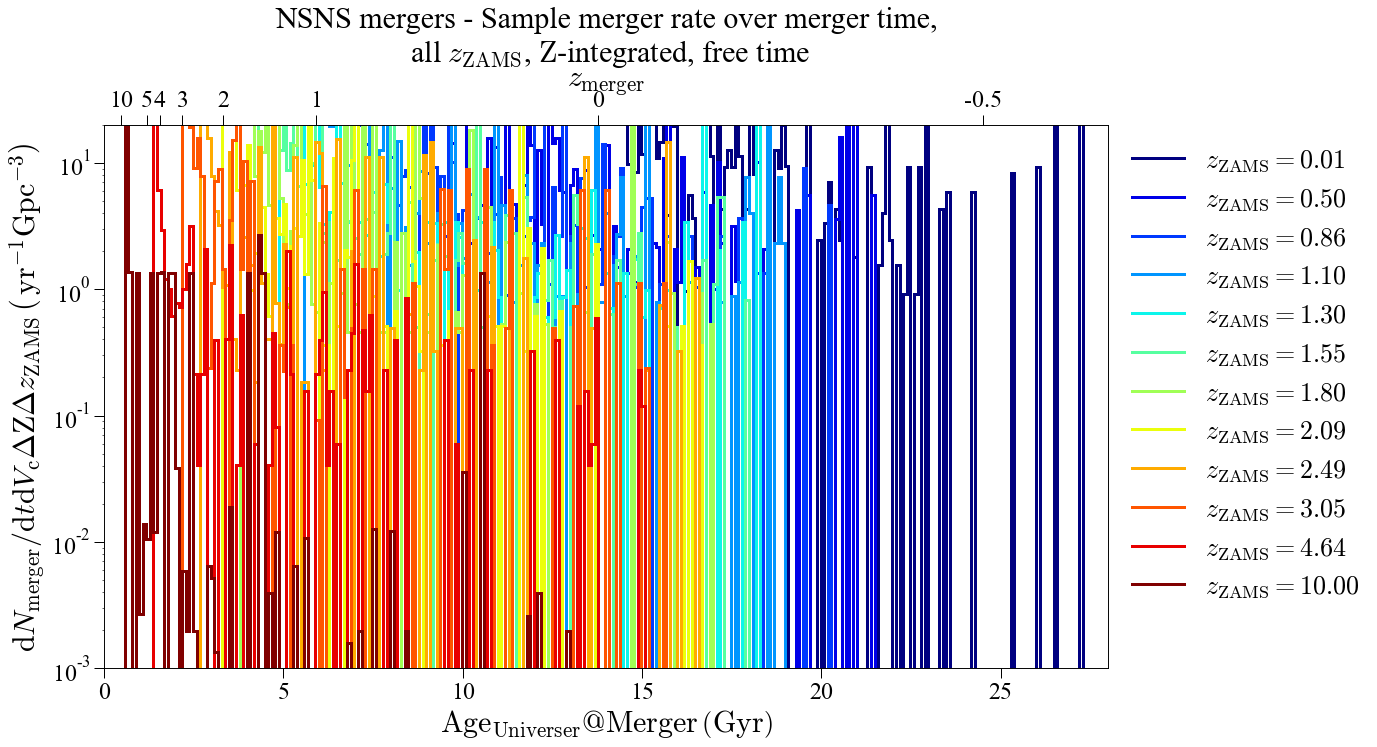

In [277]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=3)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta\mathrm{Z}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universer}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 28)

ax.set_ylim(1e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 28)
zticks = [10, 5, 4, 3, 2, 1, 0, -0.5]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

In [339]:
mergerrates._set_dz_dpopage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$ if $z_\\mathrm{ZAMS}=10$')

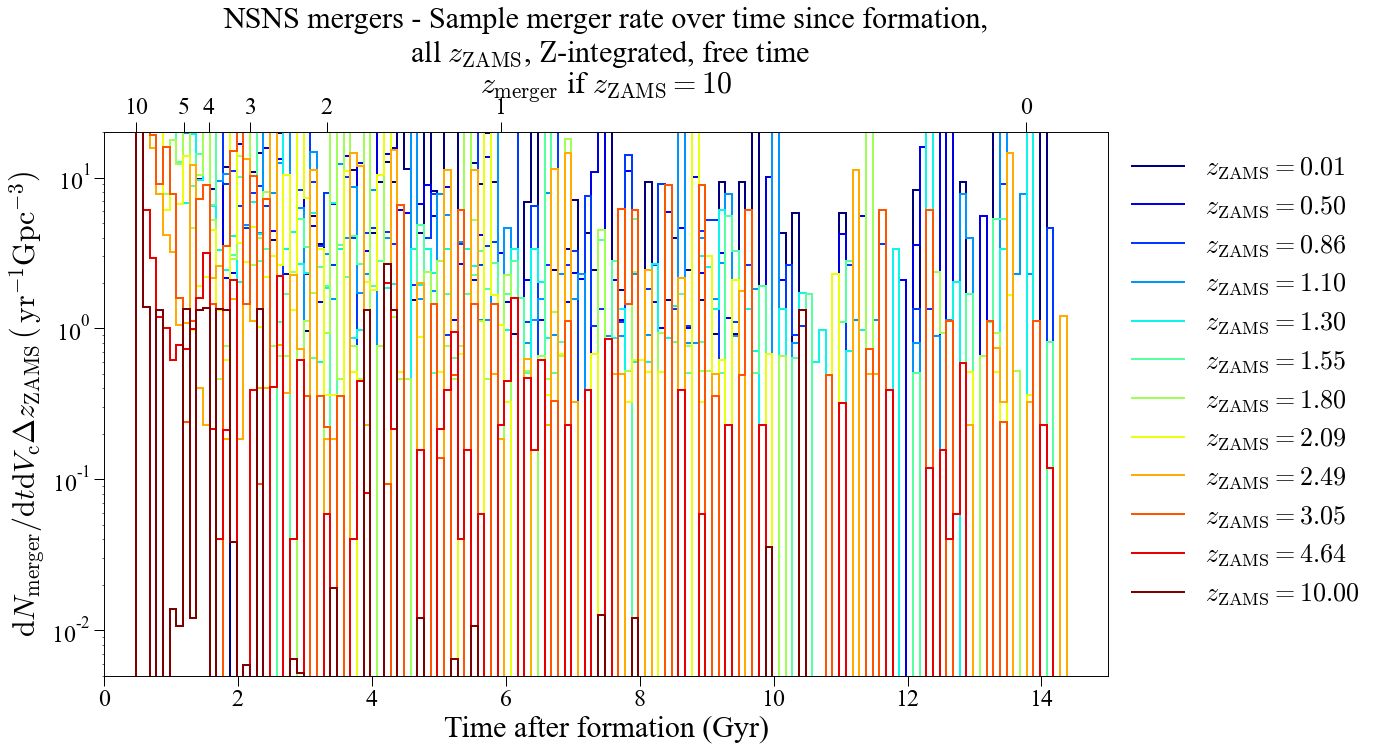

In [279]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr

cmap = cm.jet
min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cmap(c) for c in plot_colors]
plot_colors = [cmap(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for i, (redshift, redshift_mrate_array, color) in enumerate(zip(plot_redshifts, mergerrates._dz_dpopage_mrates_arr, plot_colors)):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel('Time after formation (Gyr)')
ax.set_title(f'{merger_class} mergers - Sample merger rate over time since formation,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
ax.set_ylim(5e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

In [340]:
mergerrates._set_ip_dz_dpopage_mrates_arr()

Text(0.5, 0, '$z_\\mathrm{merger}$ if $z_\\mathrm{ZAMS}=10$')

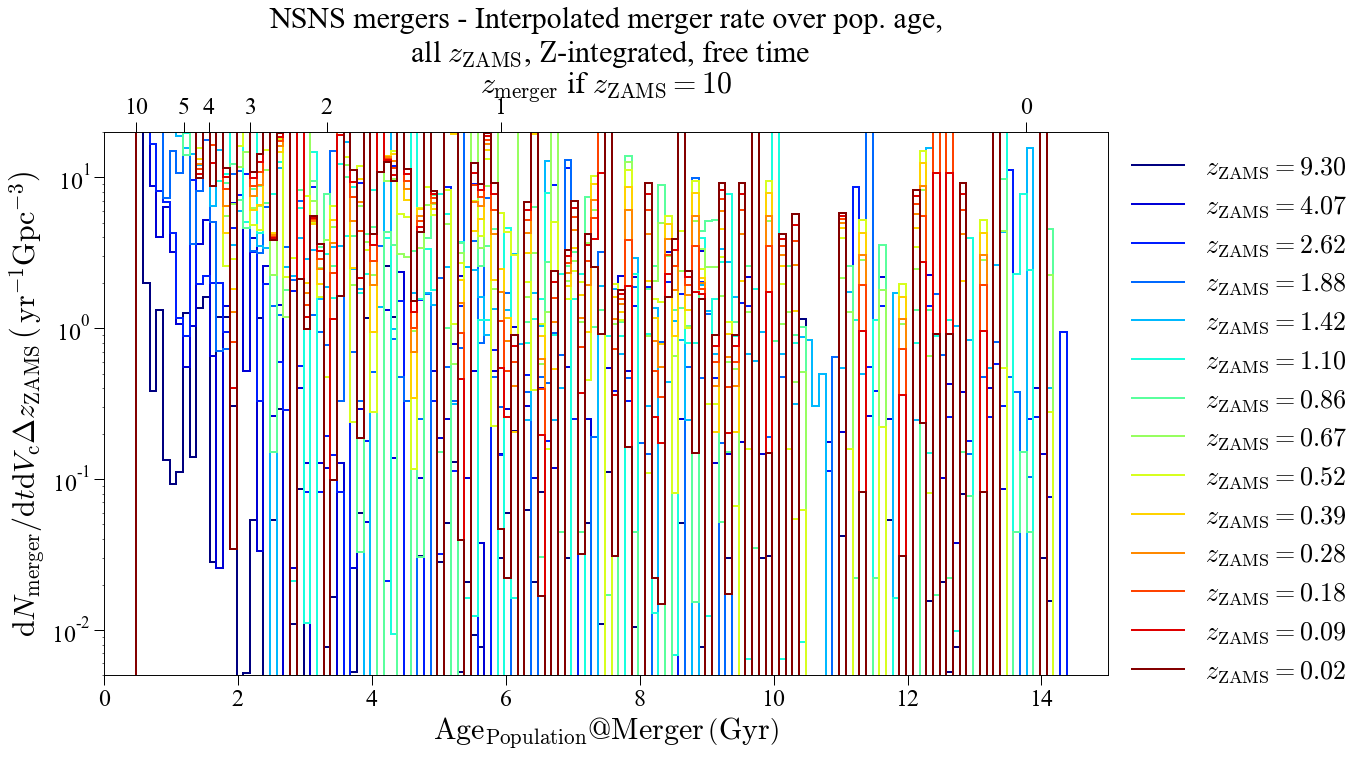

In [281]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.ip_redshift_arr

min_color = 0
plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in plot_redshifts][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts[::10], mergerrates._ip_dz_dpopage_mrates_arr[::10], plot_colors[::10]):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Population}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over pop. age,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, free time')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
ax.set_ylim(5e-3, 2e1)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

In [341]:
mergerrates._set_ip_dz_dage_mrates_arr()

[Text(13.768899116929322, 1, '0'),
 Text(5.922228427916887, 1, '1'),
 Text(3.3267847092936784, 1, '2'),
 Text(2.1782808536748703, 1, '3'),
 Text(1.5628233511789464, 1, '4'),
 Text(1.1900242903826443, 1, '5'),
 Text(0.479174188974518, 1, '10')]

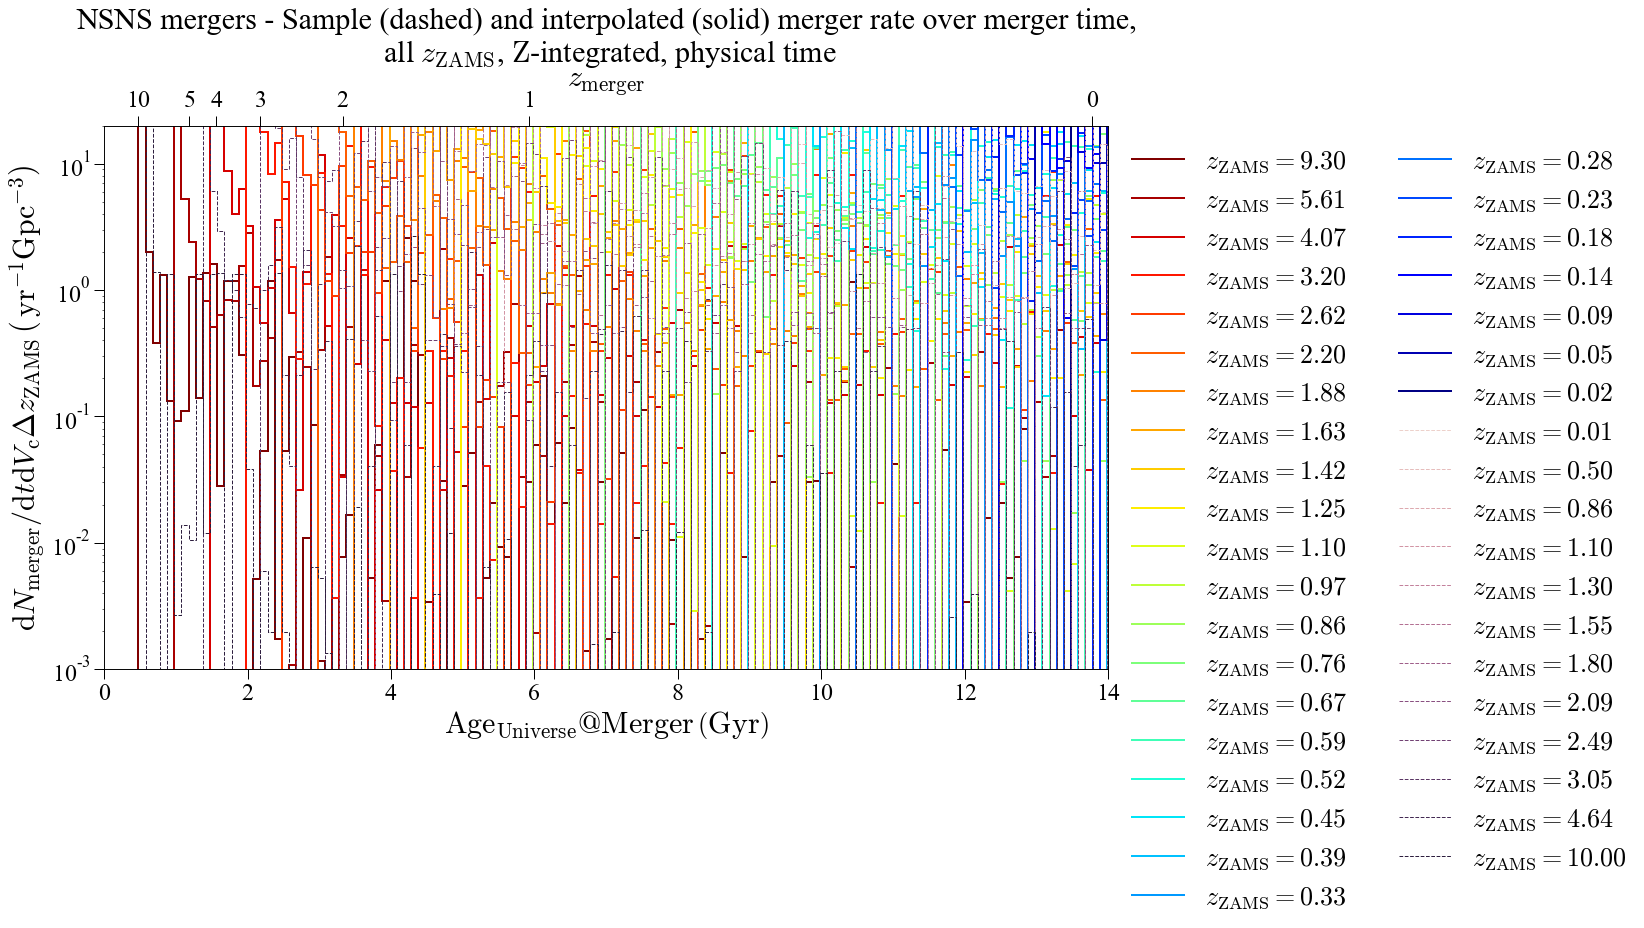

In [283]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.sample_redshift_arr
ip_plot_redshifts = mergerrates.ip_redshift_arr

#min_color = 0
#plot_colors = [(redshift-plot_redshifts.min())/(plot_redshifts.max()-plot_redshifts.min()) for redshift in ip_plot_redshifts][::-1]
#plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c  in plot_colors]
#plot_colors = [cm.jet(c) for c in plot_colors]
ip_plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(ip_plot_redshifts))[::-1]]
plot_colors = [cm_cubehelix(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(mergerrates.ip_redshift_arr[::5], mergerrates._ip_dz_dage_mrates_arr[::5], ip_plot_colors[::5]):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    

for redshift, redshift_mrate_array, color in zip(mergerrates.sample_redshift_arr, mergerrates._dz_dage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='--', lw=1, label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$')    
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1), ncol=2)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Sample (dashed) and interpolated (solid) merger rate over merger time,\n all $z_\mathrm{{ZAMS}}$, $\mathrm{{Z}}$-integrated, physical time')
#ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_yscale('log')
ax.set_ylim(1e-3, 2e1)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, 14)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

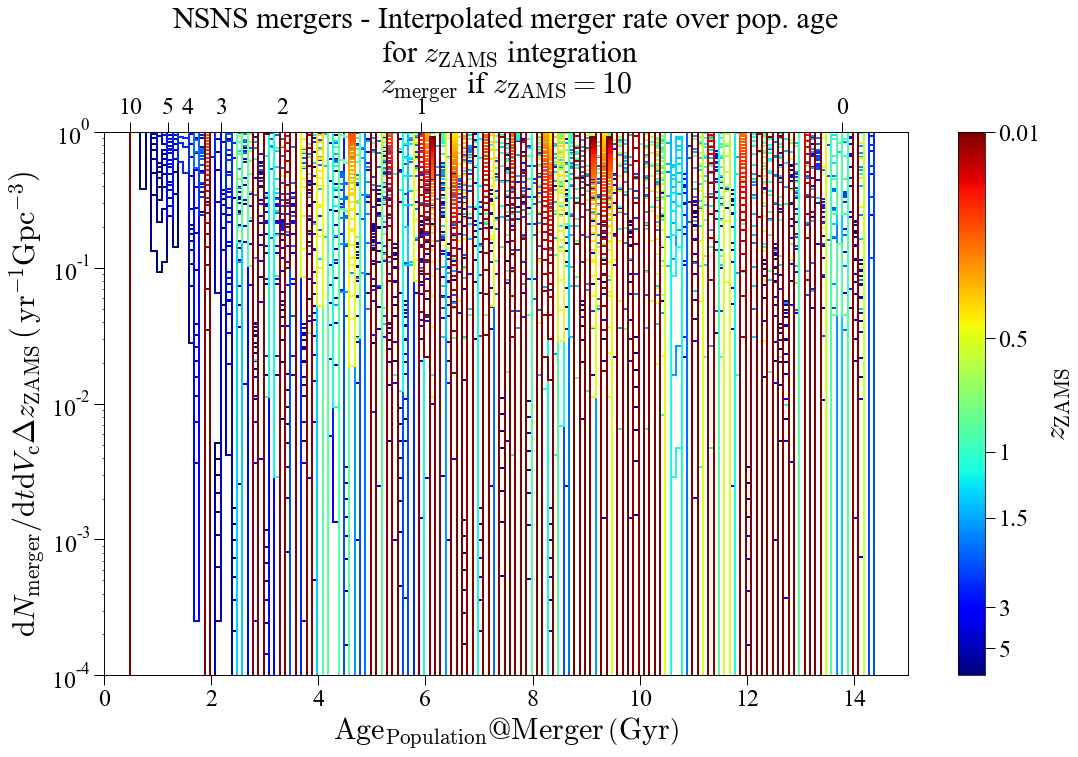

In [284]:
fig, ax = plt.subplots(figsize=(18,10))
plot_redshifts = mergerrates.ip_redshift_arr
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for redshift, redshift_mrate_array, color in zip(plot_redshifts, mergerrates._ip_dz_dpopage_mrates_arr, plot_colors):
    ax.stairs(redshift_mrate_array/y_norm, age_bin_edges, color=color, alpha=1, ls='-', label=f'$z_\mathrm{{ZAMS}}={redshift:.2f}$', lw=2)    
#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Population}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over pop. age\n for $z_\mathrm{{ZAMS}}$ integration')
#ax.invert_xaxis()
ax.set_xlim(0, 15)
#
ax.set_ylim(1e-4, 1e0)
ax.set_yscale('log')

axx2 = ax.twiny()
axx2.set_xlim(0, 15)
zticks = [10, 5, 4, 3, 2, 1, 0]
axx2.set_xticks([cosmo.age(z).value for z  in zticks])
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$ if $z_\mathrm{ZAMS}=10$')

sm = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=plot_ages.min(), vmax=plot_ages.max()))
cb = fig.colorbar(sm)
redshift_ticks = [5, 3, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

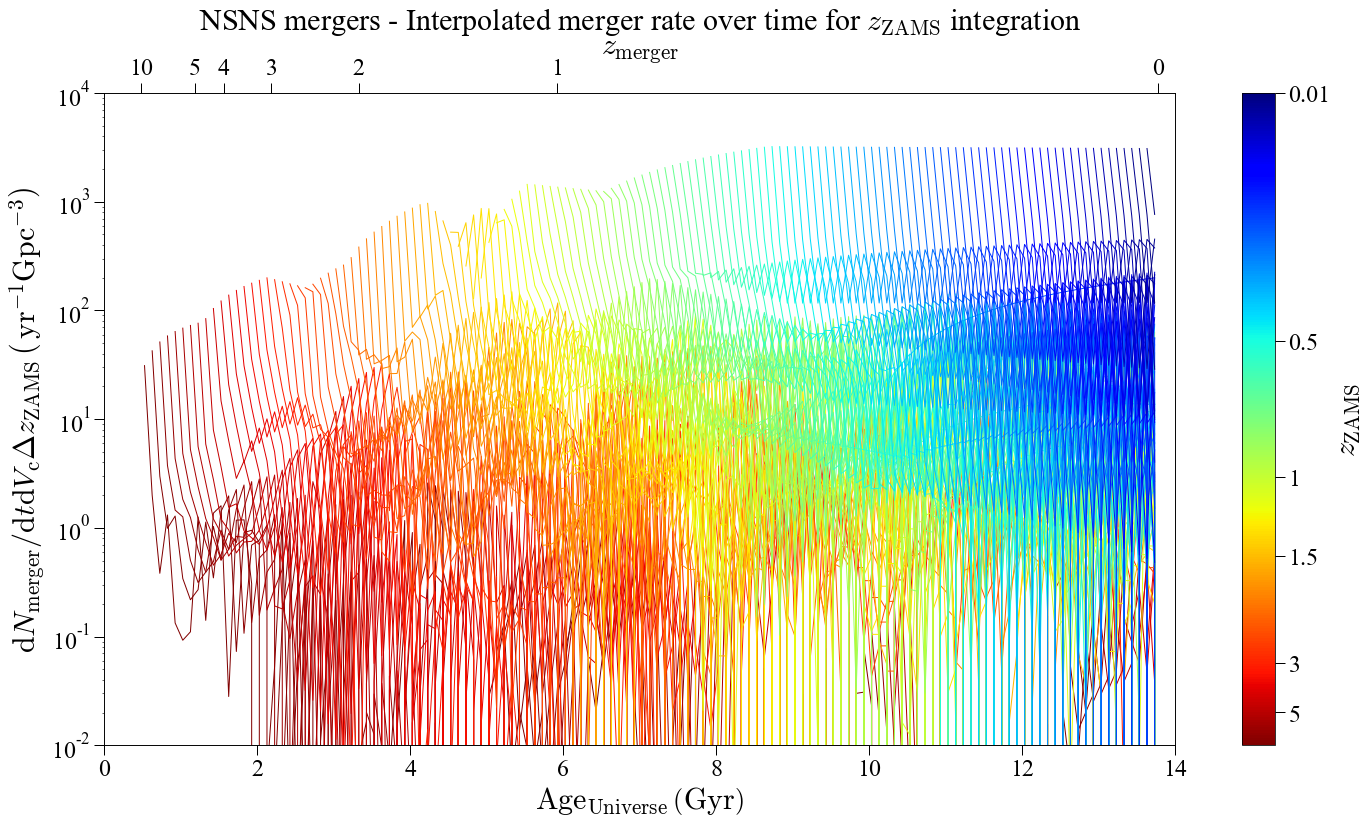

In [322]:
fig, ax = plt.subplots(figsize=(24,12))
plot_redshifts = mergerrates.ip_redshift_arr[::-1]
plot_ages = np.array([cosmo.age(z).value for z in plot_redshifts])

min_color = 0
plot_colors = [(age-plot_ages.min())/(plot_ages.max()-plot_ages.min()) for age in plot_ages][::-1]
plot_colors = [min_color+(max(plot_colors)-c)/max(plot_colors)*(1-min_color) for c in plot_colors]
plot_colors = [cm.jet(c) for c in plot_colors]
#plot_colors = [cm.jet(c) for c in np.linspace(0, 1, len(plot_redshifts))]

plot_linestyles = ['-', '--', ':']
plot_alphas = np.linspace(0.4, 1, 3)[::-1]

age_bin_centers = mergerrates._full_age_bin_centers
age_bin_edges = mergerrates._full_age_bin_edges
y_norm = 1e0
for mrate_array, color in zip(mergerrates._ip_dz_dage_mrates_arr, plot_colors):
    stop_i = next((i for i, x in enumerate(age_bin_centers) if x > cosmo.age(0).value), -1)
    start_i = next((i for i, x in enumerate(mrate_array) if x > 0), 0)
    ax.plot(age_bin_centers[start_i:stop_i], mrate_array[start_i:stop_i]/y_norm, color=color, alpha=1, ls='-', lw=1)    
    #ax.stairs(mrate_array, age_bin_edges, color=color, lw=1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}\,\left(\mathrm{Gyr}\right)$')
ax.set_title(f'{merger_class} mergers - Interpolated merger rate over time for $z_\mathrm{{ZAMS}}$ integration')
ax.invert_xaxis()
ax.set_xlim(0, 14)

ax.set_yscale('log')
ax.set_ylim(1e-2, 1e4)

axx2 = ax.twiny()
axx2.set_xlabel('$z_\mathrm{merger}$')
axx2.set_xlim(0, 14)
axx2_zticks = [0, 1, 2, 3, 4, 5, 10]
axx2.set_xticks([cosmo.age(z).value for z in axx2_zticks])
axx2.set_xticklabels([0, 1, 2, 3, 4, 5, 10])
#axx2.invert_xaxis()

sm = cm.ScalarMappable(cmap=cm.jet_r, norm=plt.Normalize(vmin=plot_ages.min(), vmax=plot_ages.max()))
cb = fig.colorbar(sm)
redshift_ticks = [5, 3, 1.5, 1, 0.5, 0.01]
age_ticks = [cosmo.age(z).value for z in redshift_ticks]
cb.set_ticks(age_ticks)
cb.set_ticklabels(redshift_ticks)
cb.set_label('$z_\mathrm{ZAMS}$')

In [342]:
mergerrates._set_dage_mrates_arr()

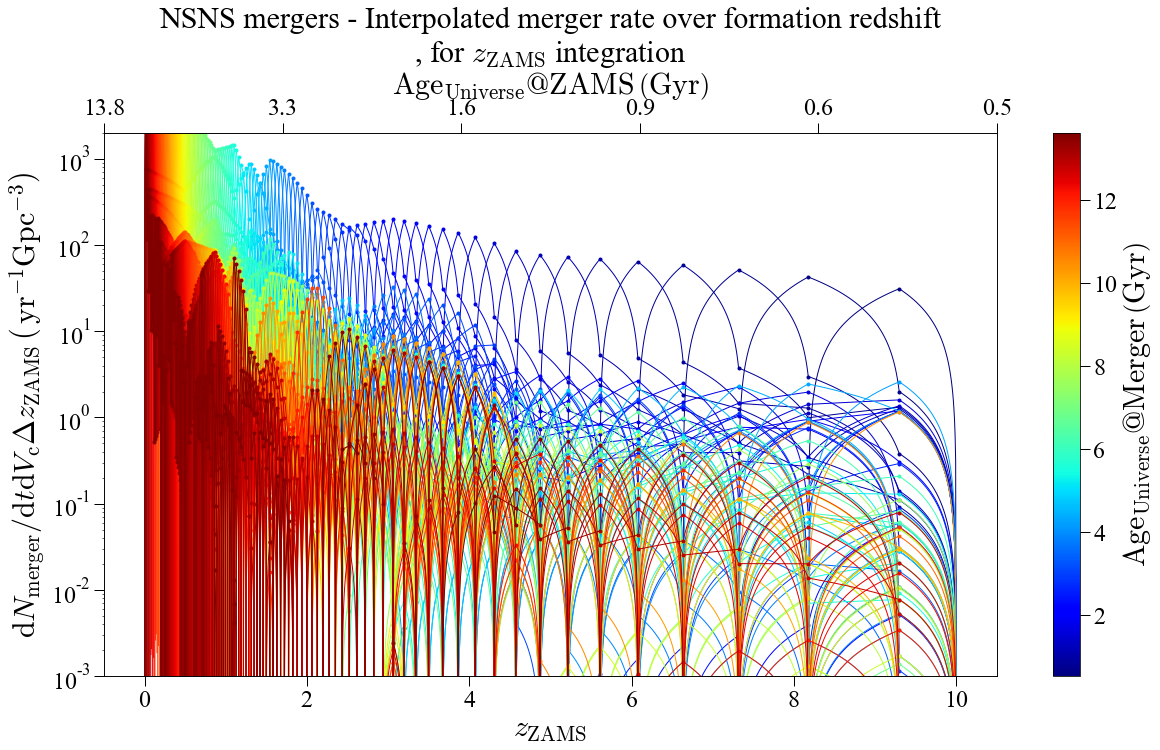

In [287]:
fig, ax = plt.subplots(figsize=(20,10))
plot_linestyles = ['-', '--', ':']
plot_linewidhts = [3, 2, 1]
plot_markerstyles = ['o', 's', '^', '*', '+', 'x']*2
plot_markersizes = [30, 20, 10]
age_bin_centers = mergerrates._physical_age_bin_centers
age_bin_edges = mergerrates._physical_age_bin_edges

plot_colors = [(age-min(age_bin_centers))/(max(age_bin_centers)-min(age_bin_centers)) for age in age_bin_centers]
plot_colors = [cm.jet(c) for c in plot_colors]

age_fits = mergerrates._per_age_redshift_fits

y_norm = 1e0
for i_age, (age, c) in enumerate(zip(age_bin_centers, plot_colors)):
    for i_redshift, redshift in enumerate(np.concatenate(([mergerrates.min_redshift], 
                                                         mergerrates.ip_redshift_arr,
                                                         [mergerrates.max_redshift]))):
        if i_redshift == 0 or i_redshift == mergerrates._ip_dz_dage_mrates_arr.shape[0]+1:
            mrate = 0
        else:
            mrate = mergerrates._ip_dz_dage_mrates_arr[i_redshift-1, i_age]
        ax.plot(redshift, mrate/y_norm, c=c, marker='o', markersize=3)
        try:
            z0, z1, slope, intercept = age_fits[i_age, i_redshift]
            #print(age_fits[i_age][i_redshift])
        except:
            pass
        finally:
            plot_zs = np.linspace(z0, z1, 100)
            plot_rates = plot_zs*slope + intercept
            #start = next((i for i, x in enumerate(plot_rates) if x), -1)
            start = 0
            ax.plot(plot_zs, plot_rates/y_norm, c=c, lw=1)
        
ax.set_yscale('log')
ax.set_ylim(1e-3, 2e3)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\Delta z_\mathrm{ZAMS}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$z_\mathrm{ZAMS}$')
ax.set_xticks([0, 2, 4, 6, 8, 10])

axx2 = ax.twiny()
zticks = [0, 2, 4, 6, 8, 10]
tticks = [f'{cosmo.age(z).value:.1f}' for z in zticks]
axx2.set_xticks(zticks)
axx2.set_xticklabels(tticks)
axx2.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{ZAMS}\,\left(\mathrm{Gyr}\right)$')

sm = cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=age_bin_centers.min(), vmax=age_bin_centers.max()))
cb = fig.colorbar(sm)
cb.set_label('$\\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\\left(\\mathrm{Gyr}\\right)$')

ax.set_title(f'{merger_class} mergers - Interpolated merger rate over formation redshift\n, for $z_\mathrm{{ZAMS}}$ integration')
age_bin_centers = mergerrates._physical_age_bin_centers

Text(0.5, 1.0, 'NSNS mergers - Merger rate over time, $z_\\mathrm{ZAMS}$ integrated')

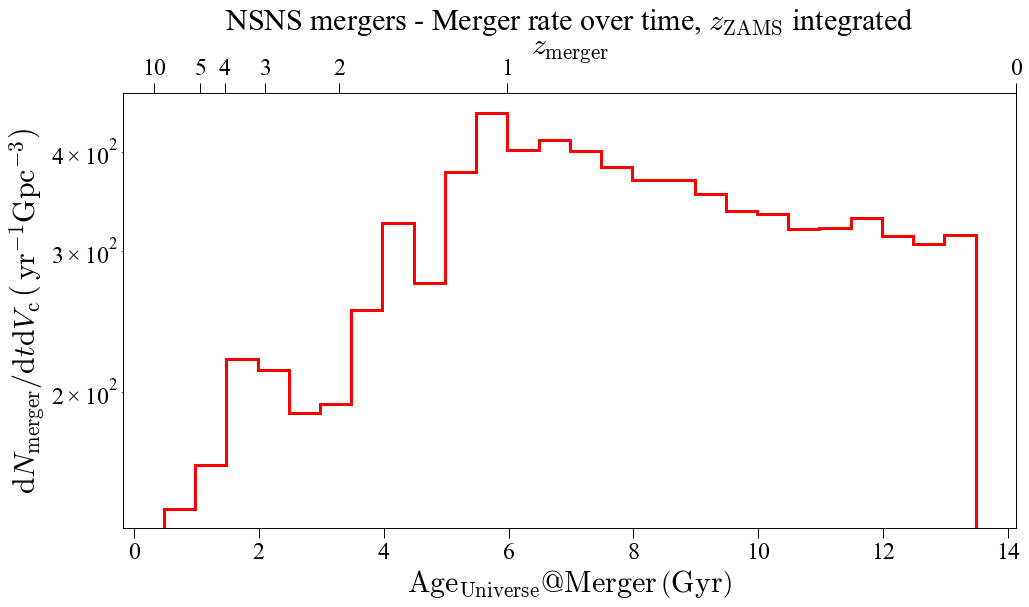

In [343]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(mergerrates.mrate_arr, mergerrates._physical_age_bin_edges, color='r', ls='-', lw=3)

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

axx2 = ax.twiny()
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'{merger_class} mergers - Merger rate over time, $z_\mathrm{{ZAMS}}$ integrated')

In [290]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(64.0461, array([0.01358125, 0.00639008]))

In [349]:
64.0461/(0.01358125-0.00639008)

8906.214148740748

In [346]:
mergerrates.mrate_arr[-1], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[-2:])

(314.4229, array([0.05833881, 0.02084678]))

In [348]:
mergerrates.mrate_arr[-1]/(mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[[-2]])-mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[[-1]]))

array([8386.39396233])

In [291]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(85.788536, array([0.79067948]))

In [345]:
max_i = np.argmax(mergerrates.mrate_arr)
mergerrates.mrate_arr[max_i], mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_edges[max_i:max_i+1])

(447.00983, array([1.11574716]))

In [292]:
redshift_bin_centers = mergerrates._get_redshift_from_age(mergerrates._physical_age_bin_centers)

In [293]:
redshift_bin_centers[[53,54,55]]

array([1.02316325, 0.99829385, 0.97407069])

In [294]:
z1_i = np.argmin(np.abs(redshift_bin_centers-1))

In [295]:
z1_redshift_centers = redshift_bin_centers[z1_i:]
z1_mrates = mergerrates.mrate_arr[z1_i:]/mergerrates.mrate_arr[-1]

In [296]:
linregress(z1_redshift_centers, z1_mrates)[:2]

(0.4203330698140575, 0.9274055813239037)

In [297]:
z1_slope, z1_intercept = linregress(z1_redshift_centers, z1_mrates)[:2]

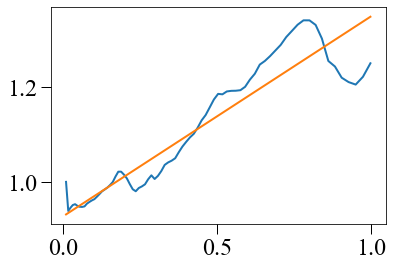

In [298]:
plt.plot(z1_redshift_centers, z1_mrates)
plt.plot(z1_redshift_centers, z1_redshift_centers*z1_slope + z1_intercept)
#plt.yscale('log')
#plt.ylim(6, 200)

In [299]:
nsns_mrates = mergerrates.mrate_arr
nsns_edges = mergerrates._physical_age_bin_edges

In [300]:
np.save(model_id+'_nsns_mrates_full.npy', nsns_mrates)
np.save(model_id+'_nsns_edges_full.npy', nsns_edges)

In [301]:
full_merger_df = mergerrates.merger_df.copy()

# Comparison

In [302]:
bhbh_mrates = np.load(model_id+'_bhbh_mrates_full.npy')
bhbh_edges = np.load(model_id+'_bhbh_edges_full.npy')
bhns_mrates = np.load(model_id+'_bhns_mrates_full.npy')
bhns_edges = np.load(model_id+'_bhns_edges_full.npy')
nsns_mrates = np.load(model_id+'_nsns_mrates_full.npy')
nsns_edges = np.load(model_id+'_nsns_edges_full.npy')

Text(0.5, 1.0, 'Merger rates over time, $z_\\mathrm{ZAMS}$ integrated')

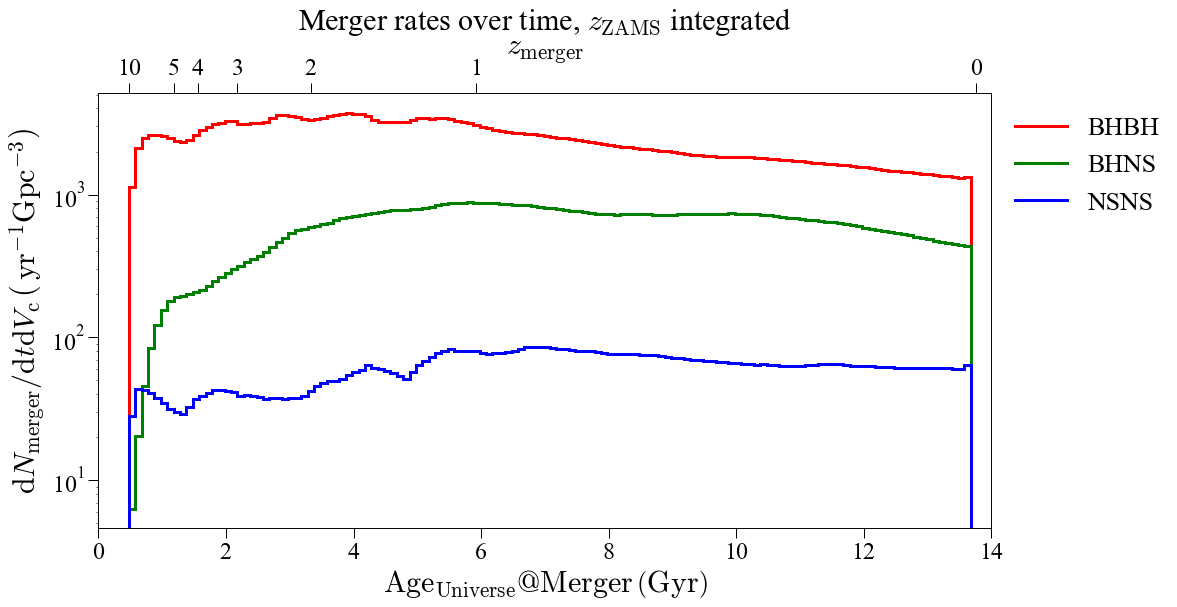

In [303]:
fig, ax = plt.subplots(figsize=(16, 8))

ynorm = 1e0
ax.stairs(bhbh_mrates, bhbh_edges, color='r', ls='-', lw=3, label='BHBH')
ax.stairs(bhns_mrates, bhns_edges, color='g', ls='-', lw=3, label='BHNS')
ax.stairs(nsns_mrates, nsns_edges, color='b', ls='-', lw=3, label='NSNS')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_yscale('log')
#ax.set_ylim(3e0,2e1)

y_norm_label = ''
if y_norm != 1:
    y_norm_label = f'10^{{{np.log10(y_norm):.0f}}}'
ax.set_ylabel(r'$\mathrm{d}N_\mathrm{merger}/\mathrm{d}t\mathrm{d}V_\mathrm{c}\,\left(%s\,\mathrm{yr}^{-1}\mathrm{Gpc}^{-3}\right)$' % y_norm_label)
ax.set_xlabel(r'$\mathrm{Age}_\mathrm{Universe}@\mathrm{Merger}\,\left(\mathrm{Gyr}\right)$')

ax.set_xlim(0, 14)
axx2 = ax.twiny()
axx2.set_xlim(0, 14)
zticks = [10, 5, 4, 3, 2, 1, 0]
tticks = [cosmo.age(z).value for z in zticks]
axx2.set_xticks(tticks)
axx2.set_xticklabels(zticks)
axx2.set_xlabel('$z_\mathrm{merger}$')

ax.set_title(f'Merger rates over time, $z_\mathrm{{ZAMS}}$ integrated')